# Analyze Heavy Correlations

This jupyter notebook analyzes one-time correlations calculated from the heavy trajectories of ReadRun.py

Observables are:
- Self-intermediate scattering function
- Mean-square displacement
- Force-force correlations
- Velocity-velocity correlations
- Force-velocity correlations

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
import os
sys.executable
from __future__ import print_function
import numpy as np
import hoomd
from hoomd import md
import gsd.pygsd
import gsd.hoomd
import lib.module_measurements as med
import lib.module_potentials as pot
from gsd import fl
from freud.box import Box
from matplotlib import pyplot as plt
from scipy.stats import sem
import copy


## Import data

Parameters

In [2]:
T=0.6
Natoms=1080
maindir='../../OUTPUT/T'+str(T)+'/N'+str(Natoms)+'/'
if T==10.0:
    samples=[0,1,2,3,4,5,6,7,8,9]
#     isoft=int(NcorrFine*0.02)
elif T==2.0:
    samples=[1,2,3,4,5,6,7,8,9]
#     isoft=int(NcorrFine*0.2)
elif T==0.6:
    samples=[0]
#     isoft=int(NcorrFine*0.3)
else:
    raise ValueError('Please do floating point comparisons properly')
# print('isoft =',isoft)
nsamples=len(samples)
doCd=False

EPS=1e-8


Read L and dt, and verify that they are consistent

In [3]:
for isam in range(nsamples):
    sam=samples[isam]
    name=maindir+'/S'+str(sam)+'/heavyTraj/L.txt'
    f=open(name,'rt')
    if 0==isam:
        L=np.float64(f.readline())
        dt=np.float64(f.readline())
    else:
        Ltemp=np.float64(f.readline())
        dttemp=np.float64(f.readline())
        if np.abs(L - Ltemp)>EPS: raise ValueError('isam %d has an incompatible L  (%.9g) with sample 0 (%.9g)'%(isam, Ltemp, L))
        if np.abs(dt-dttemp)>EPS: raise ValueError('isam %d has an incompatible dt (%.9g) with sample 0 (%.9g)'%(isam,dttemp,dt))
    f.close()
    
#Cleanup
if nsamples>1: del Ltemp, dttemp

Read positions, velocities and accelerations of all samples

In [4]:
all_times=[]
all_pos=[]
all_vel=[]
all_acc=[]
ntimes=np.zeros(nsamples,dtype=int)
for isam in range(nsamples):
    sam=samples[isam]
    sampledir=maindir+'/S'+str(sam)+'/heavyTraj/'
    #Read list of times
    timesName=sampledir+'times.txt'
    timelist=np.loadtxt(timesName)
    ntimes[isam]=len(timelist)
    print('There are ',ntimes[isam],' configurations in total')

    
    #Read accelerations
    pos = []
    vel = []
    acc = []
    fpos=open(sampledir+'/pos.npy','rb')
    fvel=open(sampledir+'/vel.npy','rb')
    facc=open(sampledir+'/acc.npy','rb')
        
    for i in range(ntimes[isam]):
        pos.append(np.load(fpos))
        vel.append(np.load(fvel))
        acc.append(np.load(facc))
    fpos.close()
    fvel.close()
    facc.close()

    
    #Relevant quantities
    if 0==isam:
        Natoms=len(pos[0])
    elif Natoms!=len(pos[0]): 
        raise ValueError('isam %d has an inconsistent Natoms=%d, inconsistent with sample 0 that has %d'%(isam,len(pos[0]),Natoms))
    initialPositions=pos[0]
    all_times.append(timelist)
    all_pos.append(pos)
    all_vel.append(vel)
    all_acc.append(acc)

del pos,vel,acc,timelist
    
all_pos=np.array(all_pos)
all_vel=np.array(all_vel)
all_acc=np.array(all_acc)



There are  28124  configurations in total


Waiting times

In [5]:
#number of trajectory starting times for each sample
ntw=np.zeros(nsamples,dtype=np.int)
twlist=[]
for isam in range(nsamples):
    twlist.append(np.unique(all_times[isam][:,0]))
    ntw[isam]=len(twlist[isam])   
print("ntw: ",ntw)


ntw:  [575]


Sort Observables

In [6]:
nt=np.zeros(nsamples,dtype=np.int)
tlist  =[]
poslist=[]
vellist=[]
acclist=[]
print(np.shape(all_pos))
for isam in range(nsamples):    
    tlist_sam  =[]
    poslist_sam=[]
    vellist_sam=[]
    acclist_sam=[]
    nt[isam]=0
    for itw in range(ntw[isam]):
        tw=twlist[isam][itw]
        this_tw=np.where(all_times[isam][:,0]==tw)
        first=this_tw[0][0]
        last=this_tw[0][-1]+1
        if last-first>nt[isam]:
            nt[isam]=last-first
            tlist_sam=np.array(all_times[isam][first:last][:,1]-all_times[isam][first][1], dtype=np.int64)
        poslist_sam.append(all_pos[isam][first:last])
        vellist_sam.append(all_vel[isam][first:last])
        acclist_sam.append(all_acc[isam][first:last])
    
    #Remove incomplete entries
    for itw in np.arange(ntw[isam]-1,-1,-1):
        if len(poslist_sam[itw]) != nt[isam]:
            assert(len(vellist_sam[itw]) == len(poslist_sam[itw]))
            assert(len(acclist_sam[itw]) == len(poslist_sam[itw]))
            del poslist_sam[itw]
            del vellist_sam[itw]
            del acclist_sam[itw]
            twlist[isam]=np.delete(twlist[isam],itw)

    #poslist, vellist and acclist have the shape: [itw, it, particle, component]

    print('ntw:',ntw[isam],end='  ')
    ntw[isam]=len(twlist[isam])
    print('ntw:',ntw[isam])

    tlist.append(tlist_sam)
    poslist.append(poslist_sam)
    vellist.append(vellist_sam)
    acclist.append(acclist_sam)
del poslist_sam,vellist_sam,acclist_sam,tlist_sam

#The following objects should be of size [nsamples, ntw, nt, Natoms, Dim]
print('ntw must be the same for all samples: ',ntw)
print('nt  must be the same for all samples: ',nt)
print(np.shape(poslist))
print(np.shape(vellist))
print(np.shape(acclist))



(1, 28124, 1080, 3)
ntw: 575  ntw: 573
ntw must be the same for all samples:  [573]
nt  must be the same for all samples:  [49]
(1, 573, 49, 1080, 3)
(1, 573, 49, 1080, 3)
(1, 573, 49, 1080, 3)


## Calculate observables

In [7]:
hoomd.context.initialize('--mode=cpu');

#READ THERMALIZED SYSTEM (for copying particle types and creating snapshots) AND POTENTIAL
sam=0
system = hoomd.init.read_gsd(filename=maindir+'/S'+str(sam)+'/thermalized.gsd')
assert(np.abs(L-system.box.Lx)<EPS)
pair=pot.LJ(md.nlist.cell(), type='KAshort')
snapA=system.take_snapshot()
snapB=system.take_snapshot()



HOOMD-blue v2.3.1-1-gb7f98d0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1080 particles


In [8]:
#Wave vector for the self-intermediate scattring function
# k =[2 pi/L](n1,n2,n3) and permutations
n1=1; n2=3; n3=4

msd = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
Fk  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CPP = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CFP = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
CFF = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
# Cd  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
obs=[{} for isam in range(nsamples+1)]
for isam in range(nsamples):
    for itw in range(ntw[isam]):
        initialPositions[:]=poslist[isam][itw][0][:]
        snapA.particles.position[:] = initialPositions[:]
        for iframe in range(0, nt[isam]):
#             print('\risam: %d, itw: %d, it: %d, Cd= %g'%(isam,itw,iframe,Cd[isam][itw][iframe]))
            snapB.particles.position[:] = poslist[isam][itw][iframe][:]
            if doCd: Cd[isam][itw][iframe]=pair.Cd_fast(snapA=snapA,snapB=snapB,beta=1./T)            
            msd[isam][itw][iframe] = med.PeriodicSquareDistance(poslist[isam][itw][iframe], initialPositions, L)/Natoms
            all_displacements= med.PeriodicDisplacement(poslist[isam][itw][iframe], initialPositions, L)
            Fk[isam][itw][iframe]  = med.ComputeFkt(n1, n2, n3, L, all_displacements)

        CPP[isam][itw]=np.array([np.mean([np.inner(vellist[isam][itw][0][atom],vellist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.
        CFP[isam][itw]=np.array([np.mean([np.inner(acclist[isam][itw][0][atom],vellist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.
        CFF[isam][itw]=np.array([np.mean([np.inner(acclist[isam][itw][0][atom],acclist[isam][itw][time][atom]) for atom in range(Natoms)]) for time in range(nt[isam])])/3.

    obs[isam]={
        'msd':{'mean': np.mean(msd[isam],axis=0), 'err': sem(msd[isam], axis=0)},
        'Fk' :{'mean': np.mean(Fk [isam],axis=0), 'err': sem(Fk [isam], axis=0)},
        'CPP':{'mean': np.mean(CPP[isam],axis=0), 'err': sem(CPP[isam], axis=0)},
        'CFP':{'mean': np.mean(CFP[isam],axis=0), 'err': sem(CFP[isam], axis=0)},
        'CFF':{'mean': np.mean(CFF[isam],axis=0), 'err': sem(CFF[isam], axis=0)},
    }
    if doCd: 
        obs[isam]['Cd']={'mean': np.mean(Cd [isam],axis=0), 'err': sem(Cd [isam], axis=0)},


In [9]:
#Obs is an nsamples-long list. Append to it the average over the samples
obs[nsamples]={
        'msd':{'mean': np.mean(msd,axis=(0,1)), 'err': sem(np.mean(msd, axis=0), axis=0)},
        'Fk' :{'mean': np.mean(Fk ,axis=(0,1)), 'err': sem(np.mean(Fk,  axis=0), axis=0)},
        'CPP':{'mean': np.mean(CPP,axis=(0,1)), 'err': sem(np.mean(CPP, axis=0), axis=0)},
        'CFP':{'mean': np.mean(CFP,axis=(0,1)), 'err': sem(np.mean(CFP, axis=0), axis=0)},
        'CFF':{'mean': np.mean(CFF,axis=(0,1)), 'err': sem(np.mean(CFF, axis=0), axis=0)},
    }
if doCd: 
    obs[nsamples]['Cd']={'mean': np.mean(Cd ,axis=(0,1)), 'err': sem(np.mean(Cd , axis=0), axis=0)},

x=tlist[0]*dt


## Plot

### Mean Square Displacement

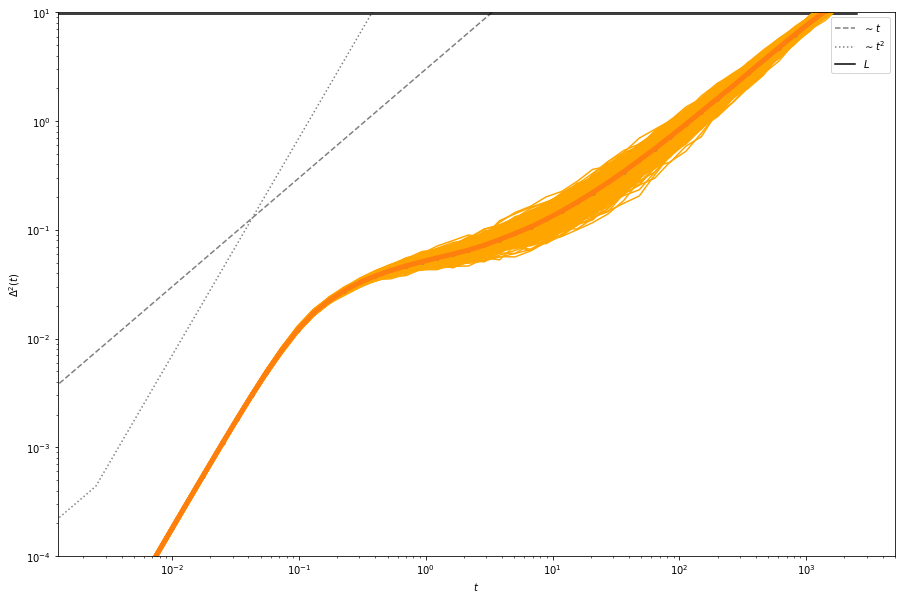

In [10]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.plot(x,3*x,label='$\sim t$',linestyle='--',color='gray')
plt.plot(x,70*np.square(x),label='$\sim t^2$',linestyle=':',color='gray')
plt.plot(x,L*np.ones(len(x)),label='$L$',color='black')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
plt.ylim((1e-4,10))
for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['msd']['mean'],yerr=obs[isam]['msd']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,msd[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['msd']['mean'],yerr=obs[nsamples]['msd']['err'], label='Average', marker='.',linewidth=5, color='blue')
plt.legend()
plt.show()



### Self-intermediate scattering function

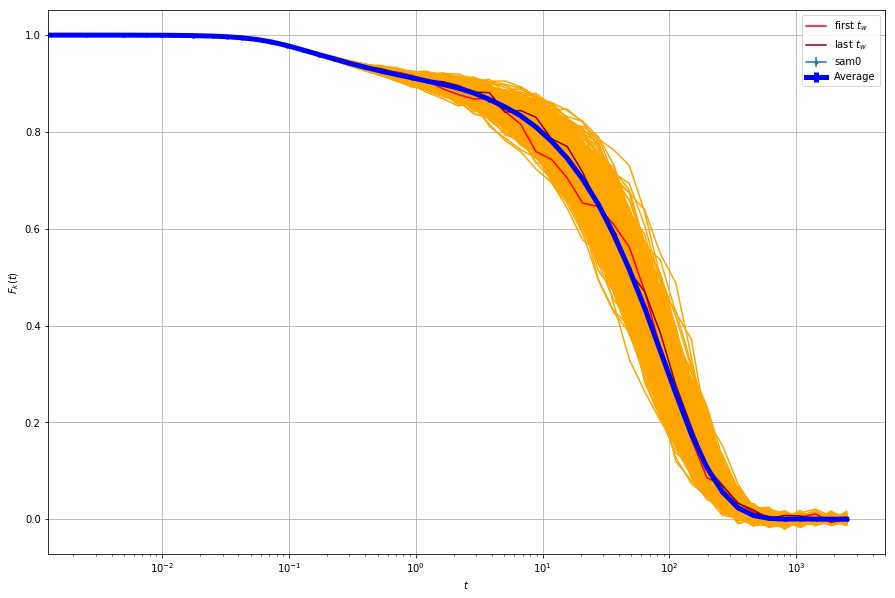

In [11]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
for isam in range(nsamples):
    for itw in range(0,ntw[isam]):
        plt.plot(x,Fk[isam][itw], color='orange')
    plt.errorbar(x,obs[isam]['Fk']['mean'],yerr=obs[isam]['Fk']['err'],label='sam'+str(samples[isam]),marker='.')
    #Highlight the first and the last tw, to show that there is no drift
    plt.plot(x,Fk[isam][0], color='red',label=r'first $t_w$')
    plt.plot(x,Fk[isam][ntw[isam]-1], color='darkred', label='last $t_w$')
plt.errorbar(x,obs[nsamples]['Fk']['mean'],yerr=obs[nsamples]['Fk']['err'],label='Average',marker='.',linewidth=5, color='blue')


plt.legend()
plt.ylabel('$F_k(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()



### Momentum-momentum correlation function

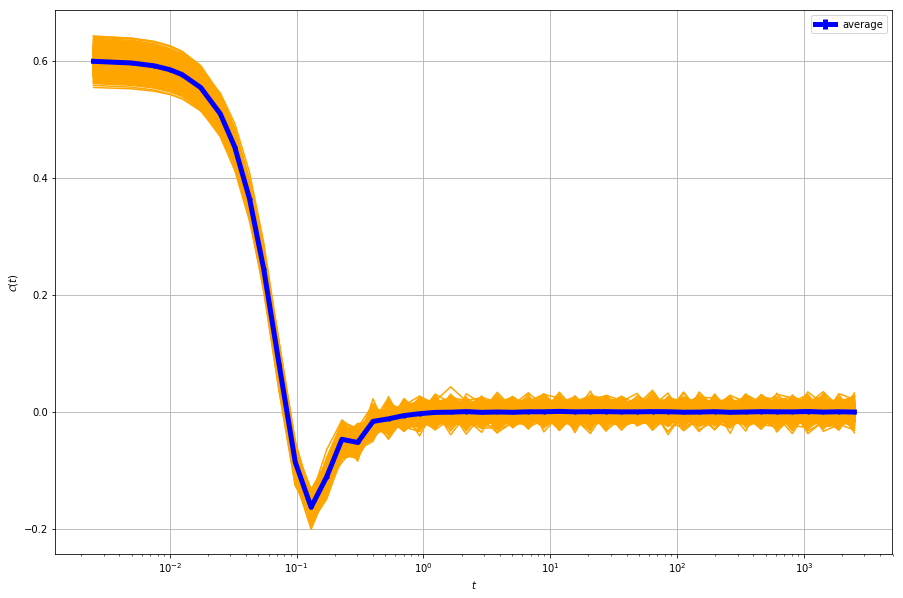

In [12]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')

for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['CPP']['mean'],yerr=obs[isam]['CPP']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CPP[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CPP']['mean'],yerr=obs[nsamples]['CPP']['err'],marker='.',label='average', linewidth=5, color='blue')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-momentum correlation function

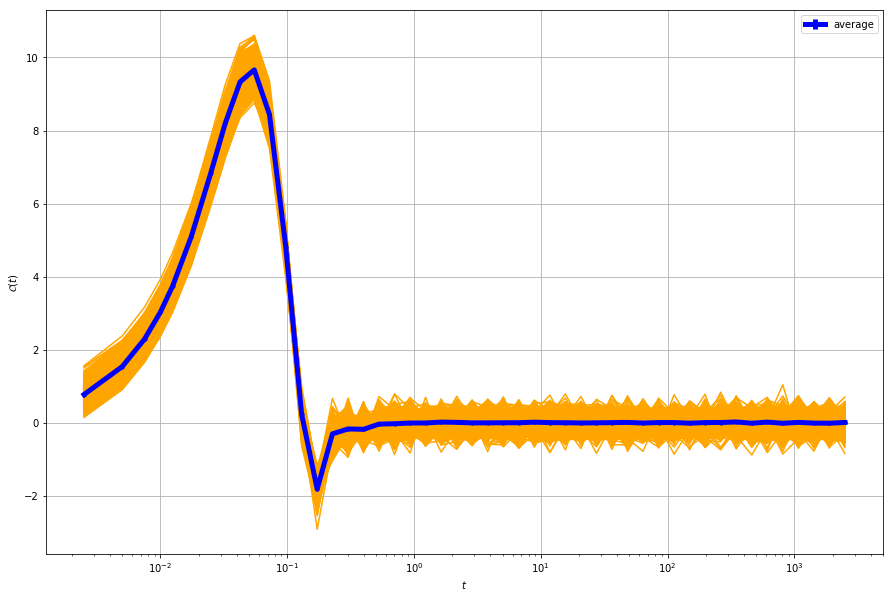

In [13]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')
for isam in range(nsamples):
    plt.errorbar(x,obs[isam]['CFP']['mean'],yerr=obs[isam]['CFP']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CFP[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CFP']['mean'],yerr=obs[nsamples]['CFP']['err'],marker='.',label='average', linewidth=5, color='blue')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-force correlation function

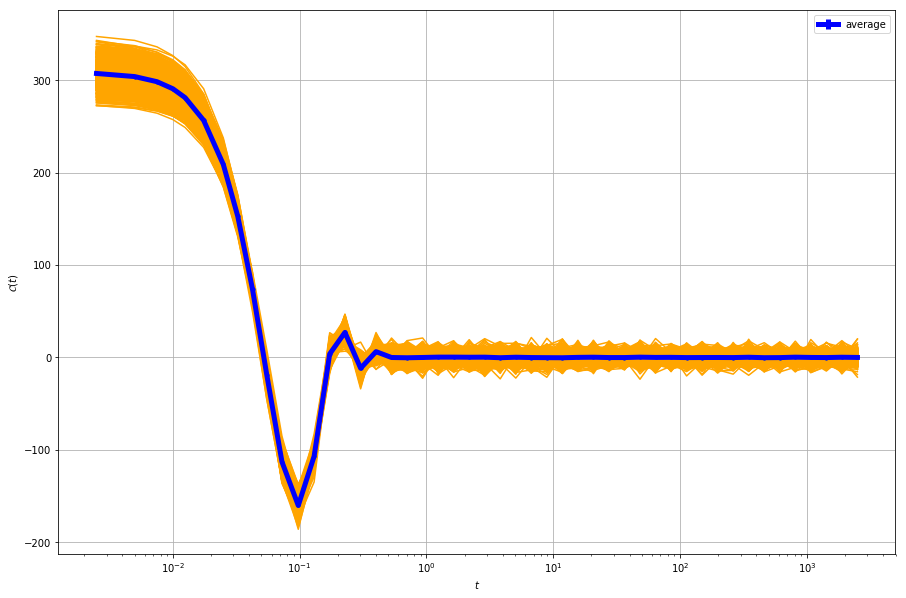

In [14]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
for isam in range(nsamples):    
    plt.errorbar(x,obs[isam]['CFF']['mean'], yerr=obs[isam]['CFF']['err'],marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,CFF[isam][itw], color='orange')
plt.errorbar(x,obs[nsamples]['CFF']['mean'], yerr=obs[nsamples]['CFF']['err'],marker='.',label='average', linewidth=5, color='blue')

plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()


### Diagonal Force correlation

In [15]:
if doCd: 
    fig=plt.figure(figsize=(15,10))
    ax=fig.add_subplot(1,1,1)
    ax.set_xscale('log', nonposx='clip')
    ax.set_yscale('log', nonposy='clip')
    plt.ylabel('$\mathcal{C}(t)$')
    plt.xlabel('$t$')
    for isam in range(nsamples):
    #     plt.errorbar(x,obs[isam]['Cd']['mean'], yerr=obs[isam]['Cd']['err'], marker='.')
        for itw in range(ntw[isam]):
            plt.plot(x,Cd[isam][itw], color='orange')
    # plt.errorbar(x,obs[nsamples]['Cd']['mean'], yerr=obs[nsamples]['Cd']['err'], marker='.',linewidth=5)
    plt.legend()
    plt.show()


# Noise correlation functions

### Integration with linear grid (though the data are logarithmic)

Parameters

In [36]:
scheme='simpson'

#The linear grid
dtfine=0.0025
invT=np.float64(1./T)
xmax=x[-1]
xdatafine=np.arange(0, xmax/50, dtfine)
NcorrFine=len(xdatafine)
du=xdatafine[1]-xdatafine[0]
print('xmax =',xmax)

xmax = 2499.9975


Some functions

In [37]:
from scipy.integrate import simps,romb
def integral(myCFP, myKold, myn, dt, scheme='rectangles'):
    '''Integral for the self-consistent calculation'''
    if n==0: return 0
    integrand=np.array([myCFP[myn-i]*myKold[i] for i in range(myn)])

    if scheme   == 'rectangles':
        output=integrand.sum()*dt
    elif scheme == 'trapeze':
        output=np.trapz(integrand,dx=dt)
    elif scheme == 'simpson':
        output=simps(integrand,dx=dt, even='first')
    else:
        raise NotImplementedError('Integration scheme must be rectangles, trapeze or simpson. '+scheme+' is not a valid option.')
    return output


Interpolation

In [38]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

#Interpolation of the correlators
interpCFF=interp1d(x, obs[nsamples]['CFF']['mean'], kind='cubic')
interpCFP=interp1d(x, obs[nsamples]['CFP']['mean'], kind='cubic')

#Correlators in the linear grid
CFP=np.copy(interpCFP(xdatafine))-obs[nsamples]['CFP']['mean'][0]
CFF=np.copy(interpCFF(xdatafine))
Kold=np.copy(interpCFF(xdatafine))
if T==10.0:
    Kold=np.exp(-35*xdatafine)*CFF[0] #This initial condition converges to the (probably) right solution when T=10
#     Kold=np.copy(KnewT10)
    isoft=int(NcorrFine*0.02)
elif T==2.0:
    Kold=np.exp(-35*xdatafine)*CFF[0]
    isoft=int(NcorrFine*0.2)
#     Kold=CFF
elif T==0.6:
    Kold=np.exp(-35*xdatafine)*CFF[0]
    isoft=int(NcorrFine*0.1)
#     Kold=CFF
Knew=np.zeros(NcorrFine,dtype=np.float64)


Smoothing starts at t=5.0
CFP(0) = 0.0


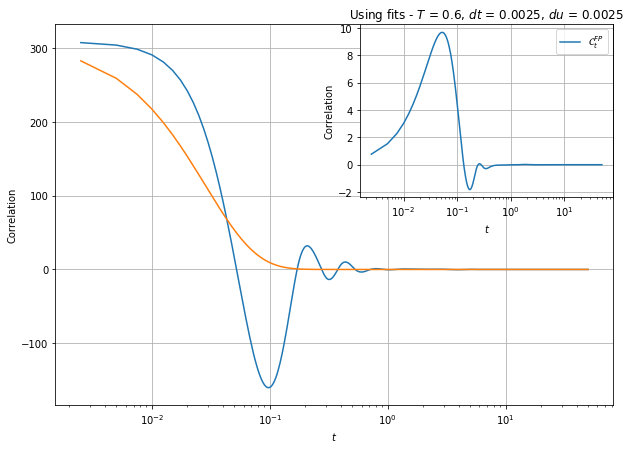

In [39]:
# isoft=NcorrFine-1
CFP[isoft:]*=[np.exp(-i/100) for i in range(0,NcorrFine-isoft)] #[1./(1+10*i) for i in range(0,NcorrFine-isoft)]
CFF[isoft:]*=[np.exp(-i/100) for i in range(0,NcorrFine-isoft)] #[1./(1+10*i) for i in range(0,NcorrFine-isoft)]
print("Smoothing starts at t={}".format(xdatafine[isoft]))
print("CFP(0) = {}".format(CFP[0]))

# plt.plot(xdatafine, Knew,label='$\mathcal{K}_t$')
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
plt.grid(True)
plt.xlabel('$t$')
plt.ylabel('Correlation')
plt.plot(xdatafine, CFF,label='$\mathcal{C}^{F}_t$')
plt.plot(xdatafine, Kold,label='$\mathcal{C}^{F}_t$')
ax = fig.add_subplot(2, 2, 2)
ax.set_xscale("log", nonposx='mask')
plt.plot(xdatafine, CFP,label='$\mathcal{C}^{FP}_t$')
plt.xlabel('$t$')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.title('Using fits - $T$ = %g, $dt$ = %g, $du$ = %g'%(T,dt,du))
plt.show()


### Integration of the noise correlation function

it: 0  err =  9.828302620964194e+58


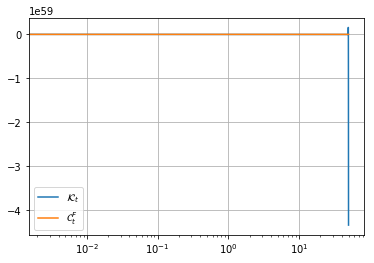

it: 1  err =  8.863607584621703e+58


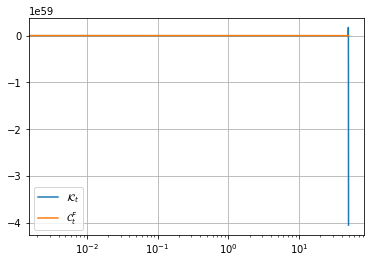

it: 2  err =  9.871797661884548e+58


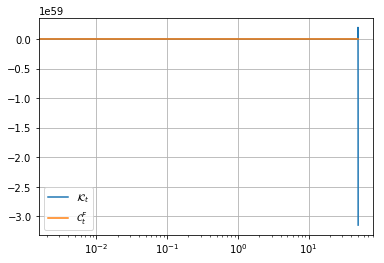

it: 3  err =  1.0759268803428634e+59


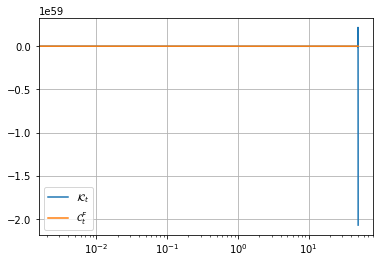

it: 4  err =  9.617200371860591e+58


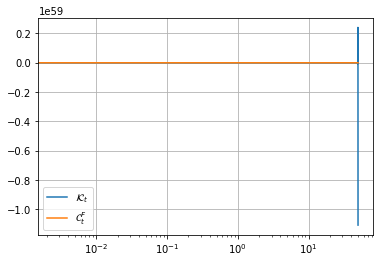

it: 5  err =  7.19522745751536e+58


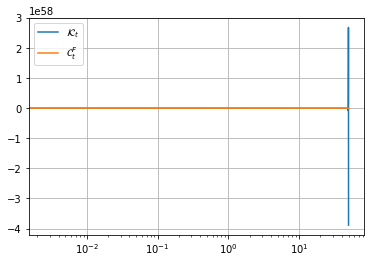

it: 6  err =  4.5538642676245596e+58


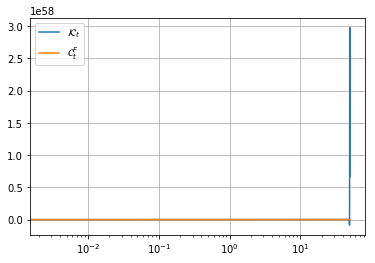

it: 7  err =  2.2987891277421324e+58


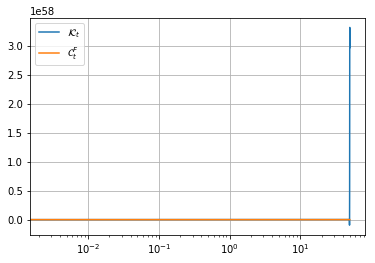

it: 8  err =  6.760066915421504e+57


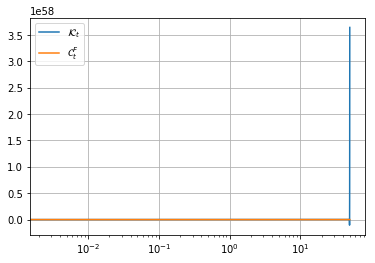

it: 9  err =  7.266365770812146e+57


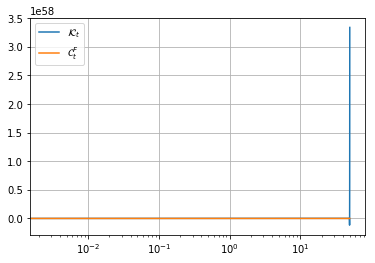

it: 10  err =  8.077707384017789e+57


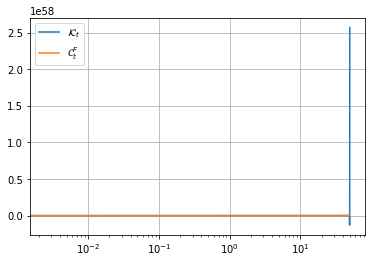

it: 11  err =  8.670576933285254e+57


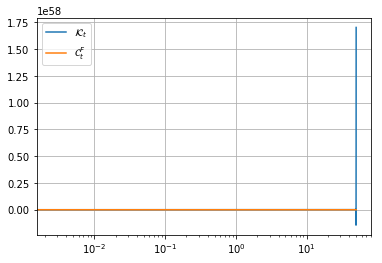

it: 12  err =  7.603564524775466e+57


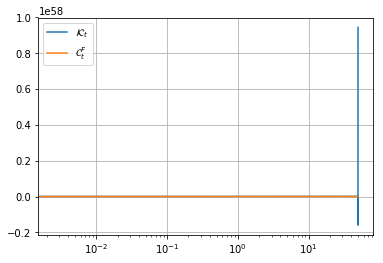

it: 13  err =  5.656657422383103e+57


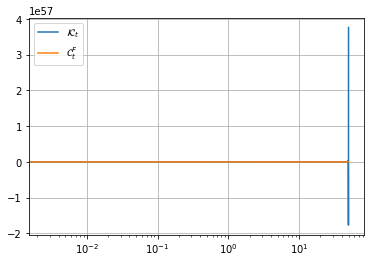

it: 14  err =  3.614102612316881e+57


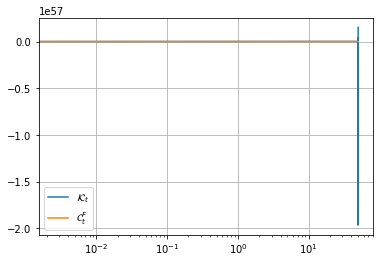

it: 15  err =  1.899818892973309e+57


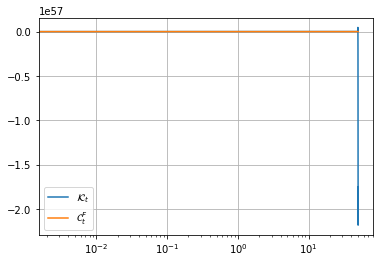

it: 16  err =  6.709150171290952e+56


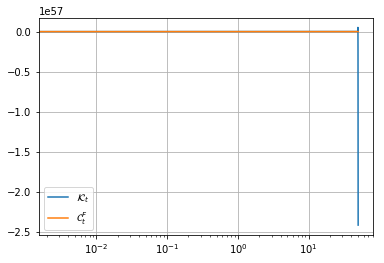

it: 17  err =  4.61926671936408e+56


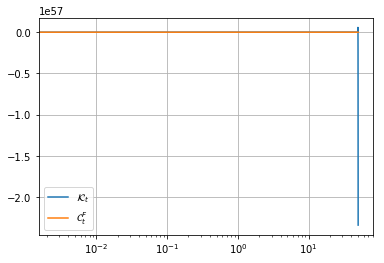

it: 18  err =  5.126570234489727e+56


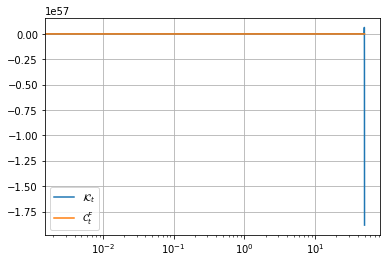

it: 19  err =  5.631802072109444e+56


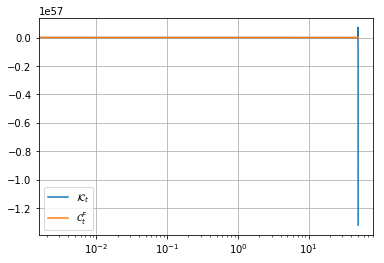

it: 20  err =  5.182231325734947e+56


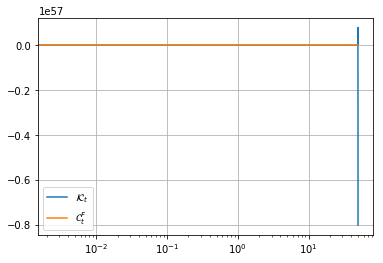

it: 21  err =  4.032750047799561e+56


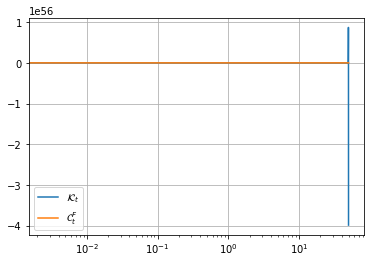

it: 22  err =  2.736188491417465e+56


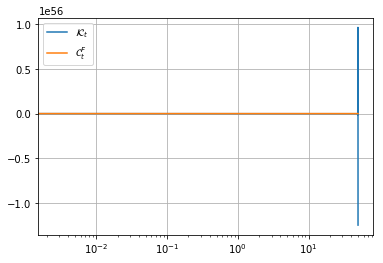

it: 23  err =  1.5984813464376316e+56


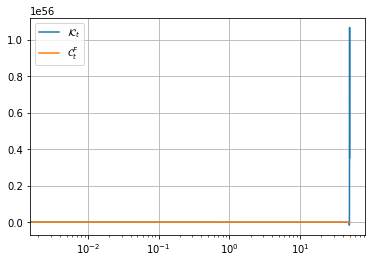

it: 24  err =  7.445601036559137e+55


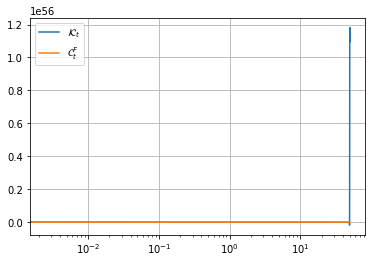

it: 25  err =  2.18271957819678e+55


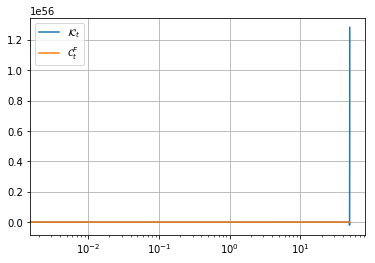

it: 26  err =  2.418020371779065e+55


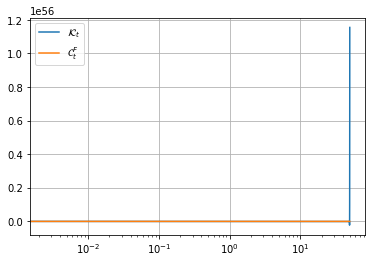

it: 27  err =  2.67839467822353e+55


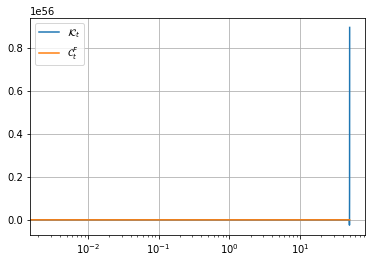

it: 28  err =  2.8166783001712103e+55


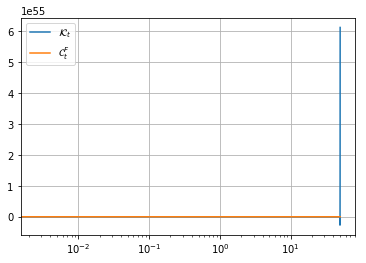

it: 29  err =  2.4358295983308892e+55


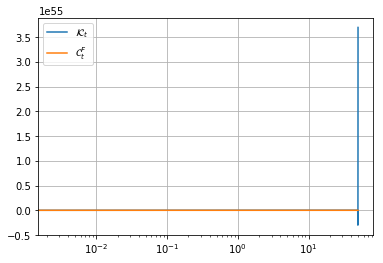

it: 30  err =  1.8282399416698648e+55


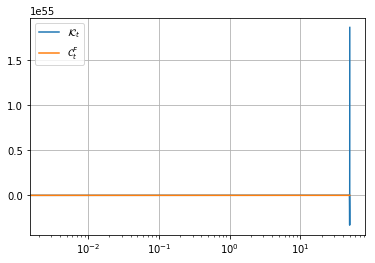

it: 31  err =  1.2152146491169266e+55


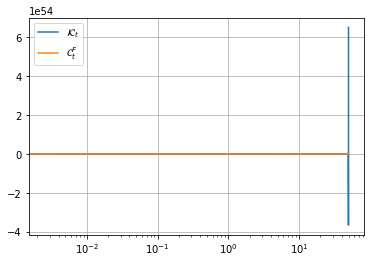

it: 32  err =  7.063367051376656e+54


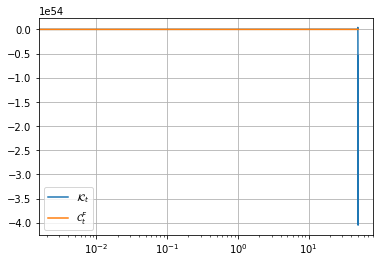

it: 33  err =  3.368019040583737e+54


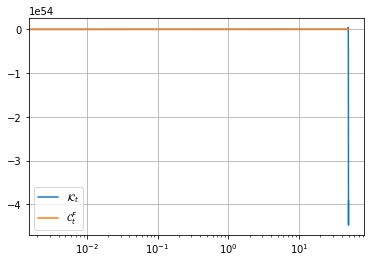

it: 34  err =  9.921327224329598e+53


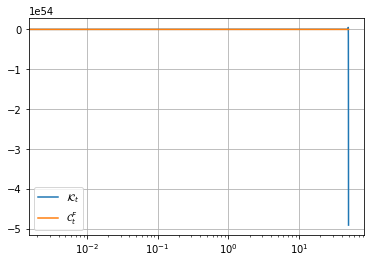

it: 35  err =  8.823833969249186e+53


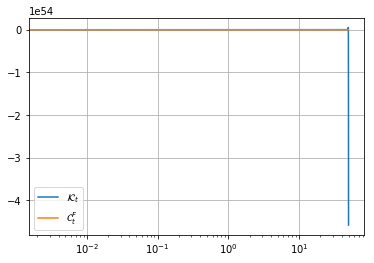

it: 36  err =  9.755751271444671e+53


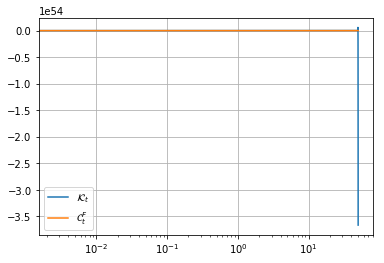

it: 37  err =  1.0480293455254618e+54


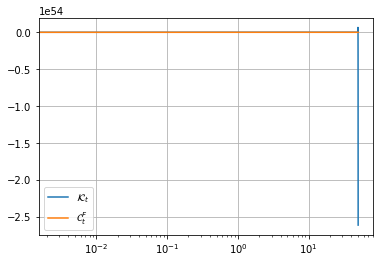

it: 38  err =  9.349334327114936e+53


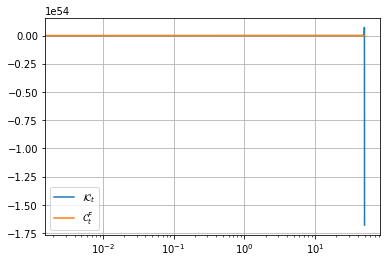

it: 39  err =  7.245333615578413e+53


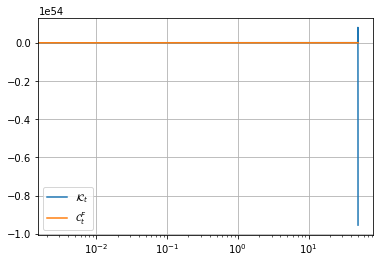

it: 40  err =  5.0317782070996935e+53


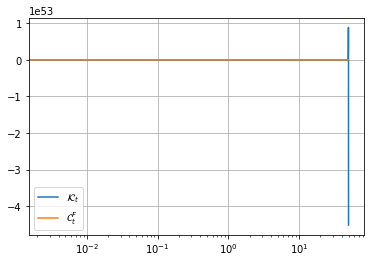

it: 41  err =  3.13989364121164e+53


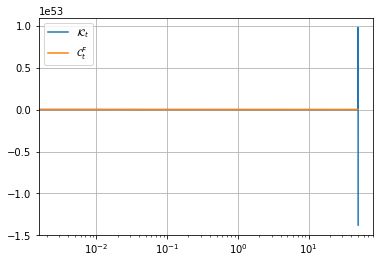

it: 42  err =  1.7197985866643922e+53


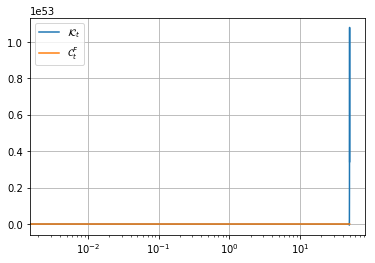

it: 43  err =  7.620678473369956e+52


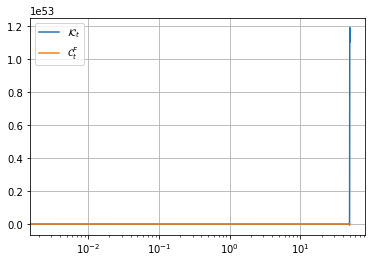

it: 44  err =  2.0493562043000472e+52


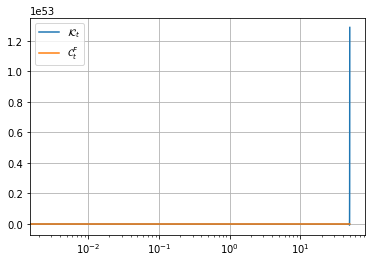

it: 45  err =  2.2611692889384613e+52


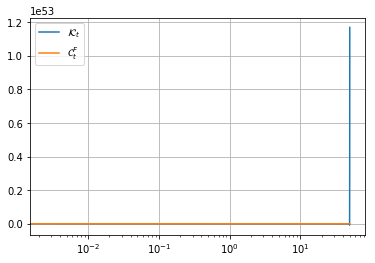

it: 46  err =  2.4954343445932465e+52


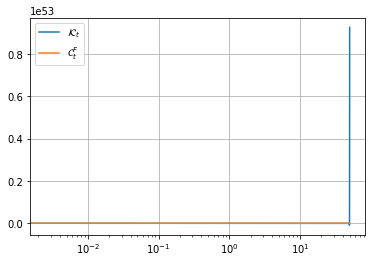

it: 47  err =  2.61432972756295e+52


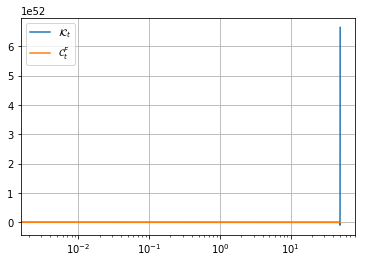

it: 48  err =  2.277249662659496e+52


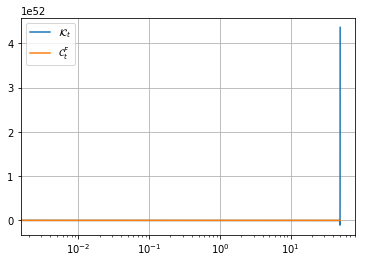

it: 49  err =  1.752636814492585e+52


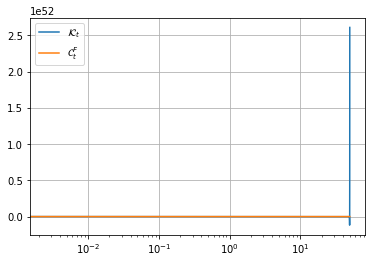

it: 50  err =  1.2268106336387167e+52


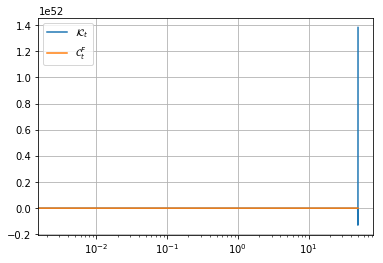

it: 51  err =  7.863352188765112e+51


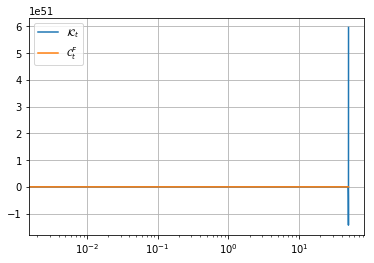

it: 52  err =  4.570487198953044e+51


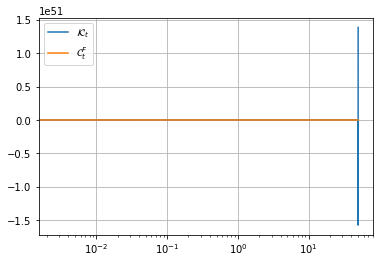

it: 53  err =  2.324613042826275e+51


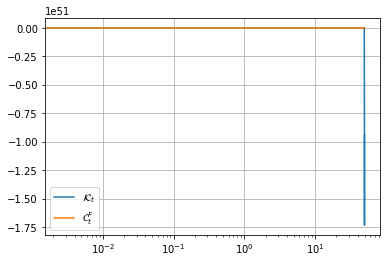

it: 54  err =  9.23259104668392e+50


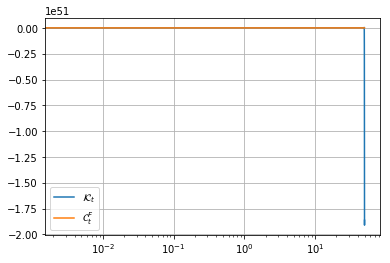

it: 55  err =  3.15797799840555e+50


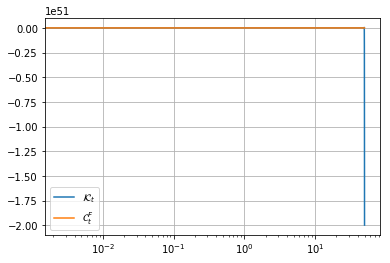

it: 56  err =  3.4775827907232306e+50


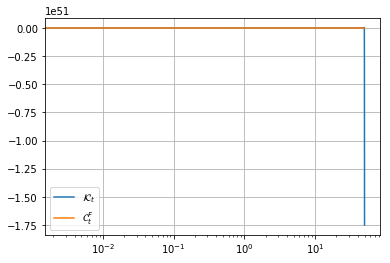

it: 57  err =  3.82936320090604e+50


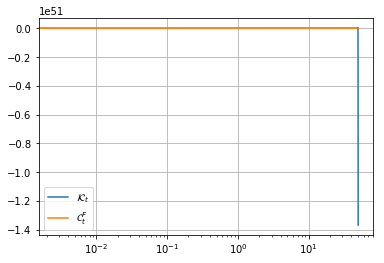

it: 58  err =  3.8357585728030045e+50


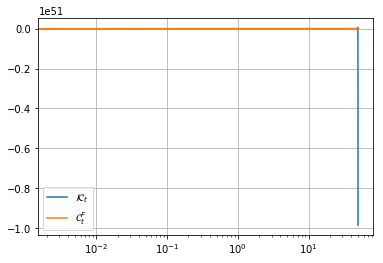

it: 59  err =  3.244781216095127e+50


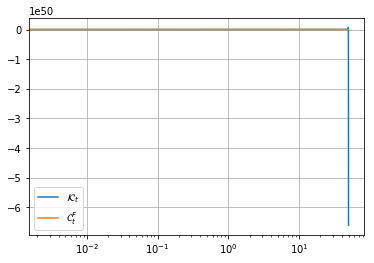

it: 60  err =  2.4732221377911684e+50


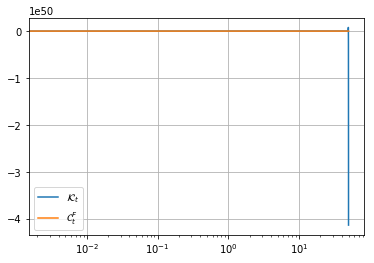

it: 61  err =  1.742329001008457e+50


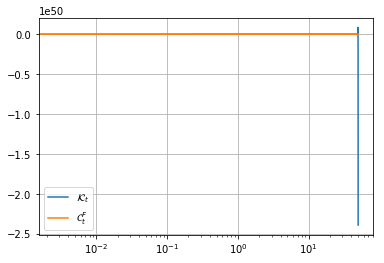

it: 62  err =  1.1448734243786199e+50


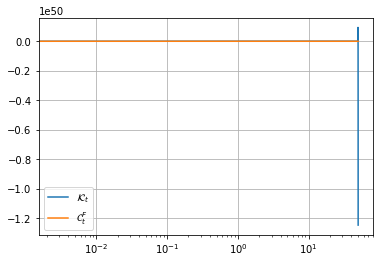

it: 63  err =  7.010040137737568e+49


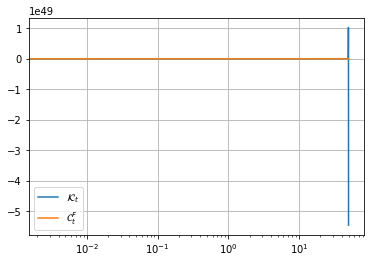

it: 64  err =  3.951930668430339e+49


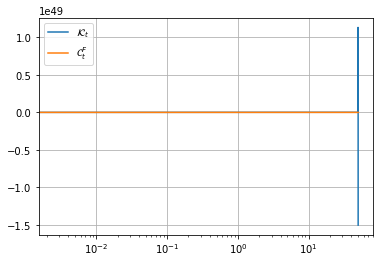

it: 65  err =  1.985614509940184e+49


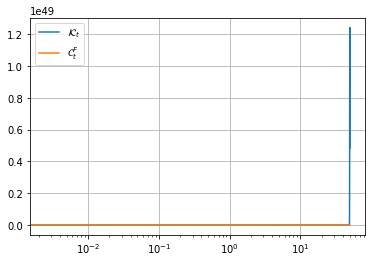

it: 66  err =  8.097703266494305e+48


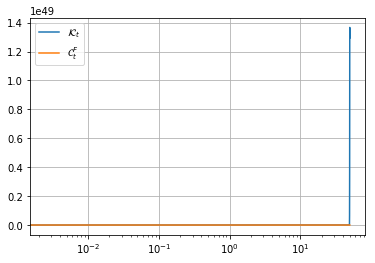

it: 67  err =  2.165519564181056e+48


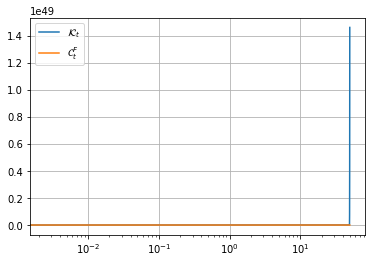

it: 68  err =  2.3791800159491218e+48


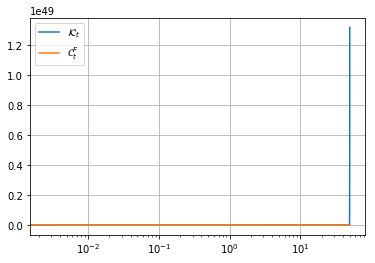

it: 69  err =  2.614260562104868e+48


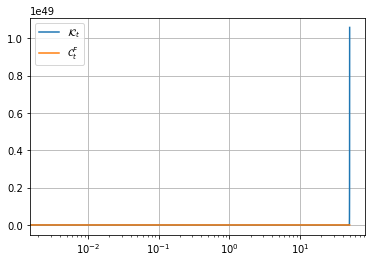

it: 70  err =  2.6926640101814337e+48


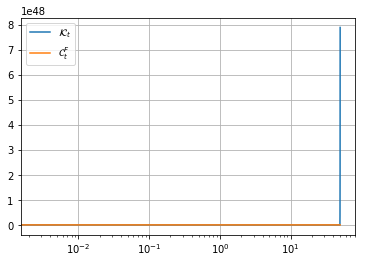

it: 71  err =  2.3389727987535295e+48


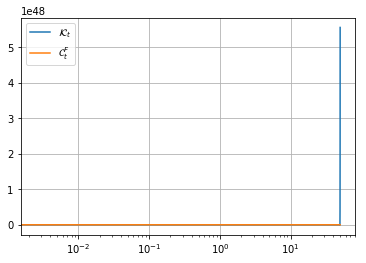

it: 72  err =  1.834826453137852e+48


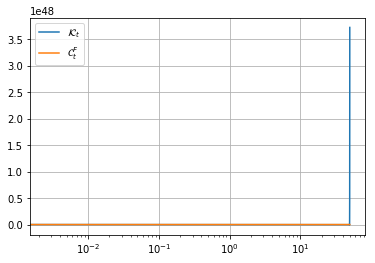

it: 73  err =  1.3419053746160869e+48


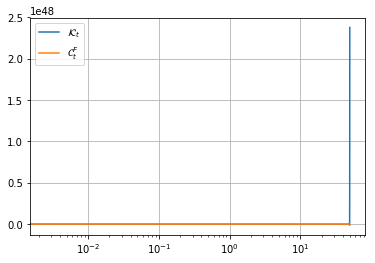

it: 74  err =  9.285929178519515e+47


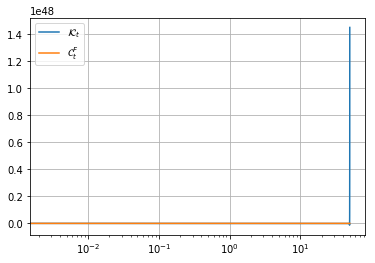

it: 75  err =  6.121898682472936e+47


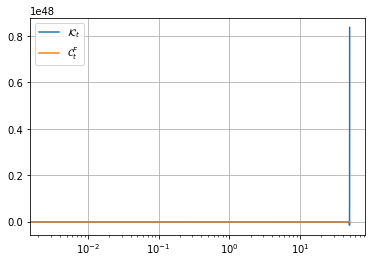

it: 76  err =  3.852641224248693e+47


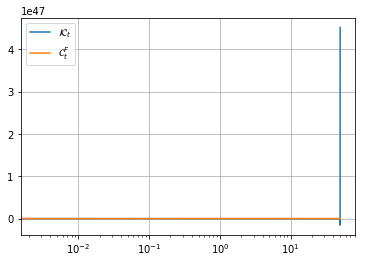

it: 77  err =  2.3091179105135628e+47


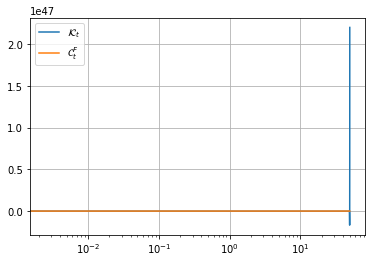

it: 78  err =  1.3080059033022595e+47


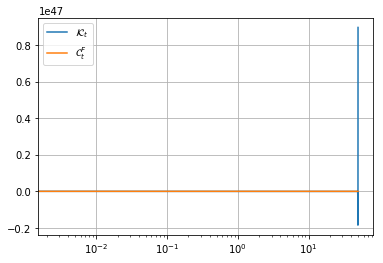

it: 79  err =  6.883327939498432e+46


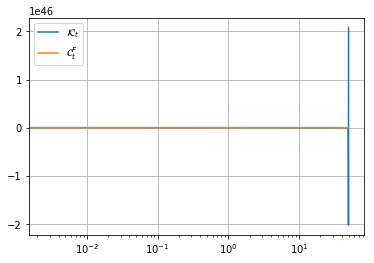

it: 80  err =  3.235642231999792e+46


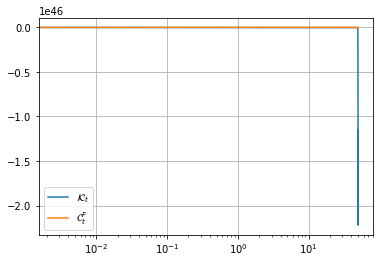

it: 81  err =  1.2132624962986962e+46


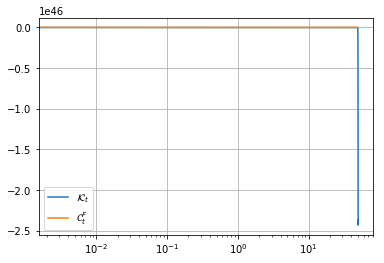

it: 82  err =  3.663567966087842e+45


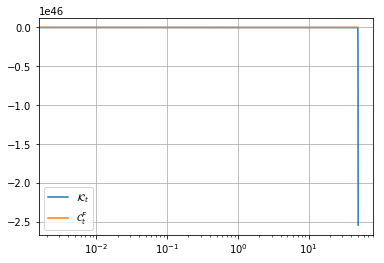

it: 83  err =  4.0146095899878393e+45


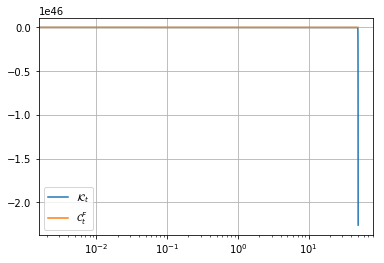

it: 84  err =  4.399354494027761e+45


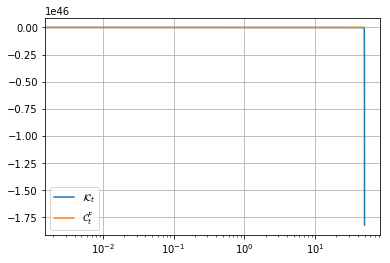

it: 85  err =  4.408880101576477e+45


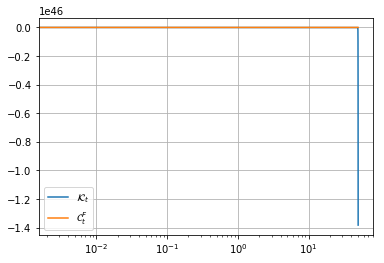

it: 86  err =  3.7872008612435013e+45


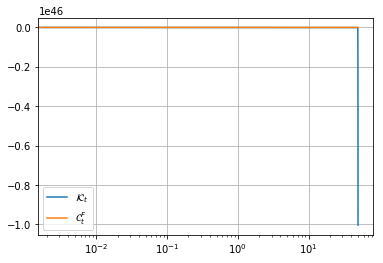

it: 87  err =  2.987022771178001e+45


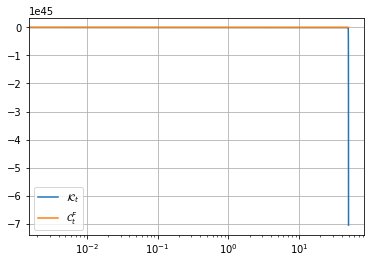

it: 88  err =  2.228494269894174e+45


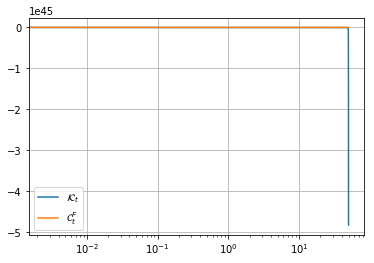

it: 89  err =  1.5970266825237895e+45


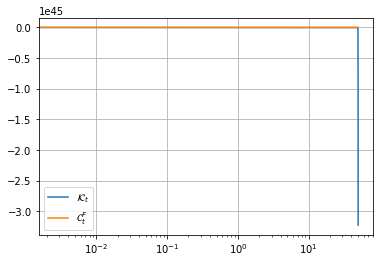

it: 90  err =  1.1093460769441501e+45


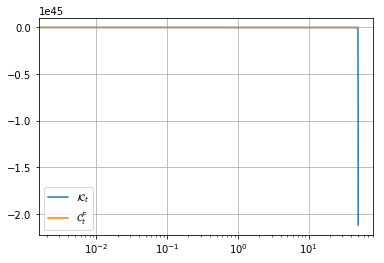

it: 91  err =  7.512749415540422e+44


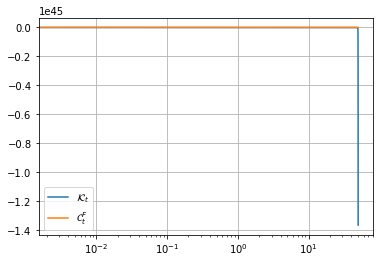

it: 92  err =  4.980074800533441e+44


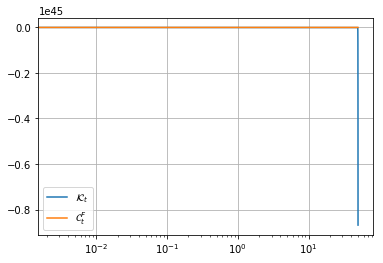

it: 93  err =  3.2405673531195664e+44


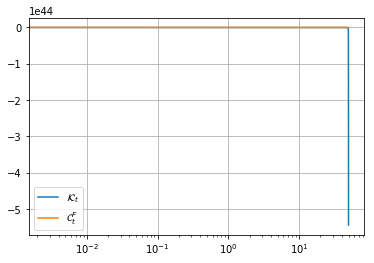

it: 94  err =  2.0743584886297835e+44


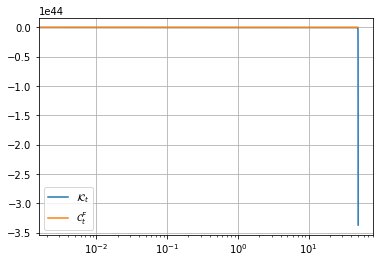

it: 95  err =  1.3084011814375613e+44


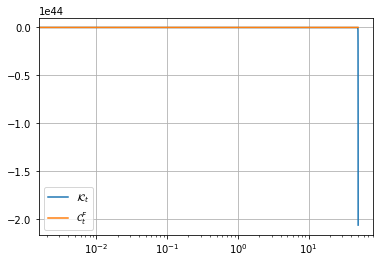

it: 96  err =  8.142534985614454e+43


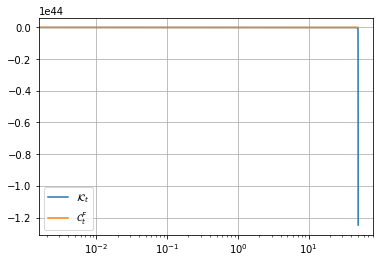

it: 97  err =  5.004936947045987e+43


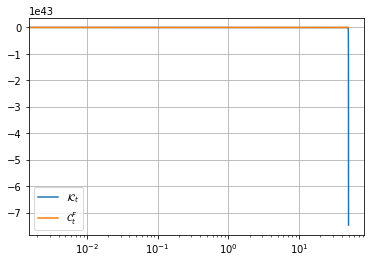

it: 98  err =  3.0411344444309886e+43


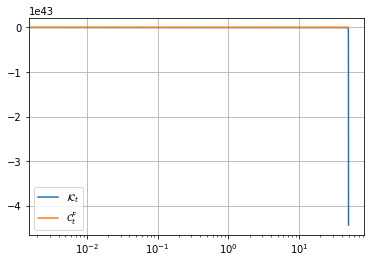

it: 99  err =  1.8280443037344349e+43


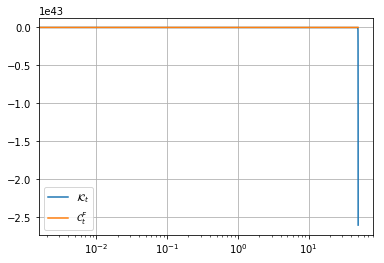

KeyboardInterrupt: 

In [44]:
maxiter=1500
err=1

for it in range(maxiter):
    for n in range(NcorrFine):
        Knew[n] = CFF[n] + invT * integral(CFP, Kold,n, dtfine,scheme=scheme)
    err=np.max(np.abs(Knew-Kold))
    print("it:",it," err = ",err)
    Kold[:]=Knew[:]
#     Kold[isoft:]=0
#     Kold[isoft:]*=[1./(1+i) for i in range(0,NcorrFine-isoft)]
#     plt.semilogx(xdatafine, Knew,label='$\mathcal{K}_t$')
    plt.semilogx(xdatafine, Kold,label='$\mathcal{K}_t$')
    plt.plot(xdatafine, interpCFF(xdatafine),label='$\mathcal{C}^{F}_t$')
#     plt.plot(xdatafine, np.zeros(NcorrFine),color='black')
    plt.grid()
    plt.legend()
    plt.show()
    if err<1e-10: break


In [41]:
Ksave=np.copy(Kold)

/usr/local/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


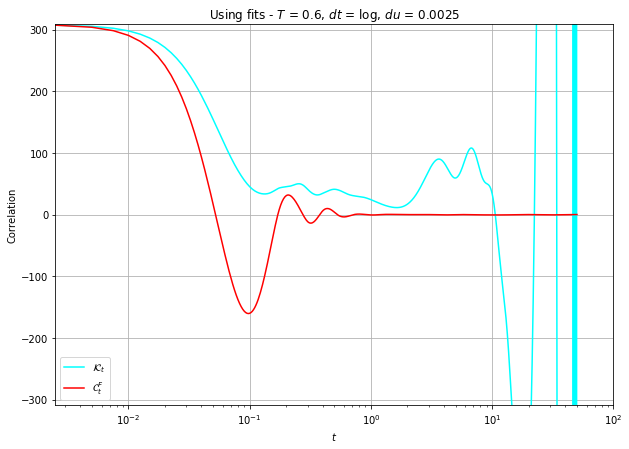

In [43]:
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log")
ax.set_yscale("linear")
# plt.plot(xdatafine, Kall[0],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[1],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[2],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[3],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[4],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[5],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[6],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[7],label='$\mathcal{K}_t$',color='blue')
# plt.plot(xdatafine, Kall[8],label='$\mathcal{K}_t$',color='blue')
# plt.errorbar(xdatafine,Kav, yerr=sem(Kall), marker='.')
plt.plot(xdatafine, Knew,label='$\mathcal{K}_t$',color='cyan')
plt.plot(xdatafine, interpCFF(xdatafine),label='$\mathcal{C}^{F}_t$',color='red')
plt.xlabel('$t$')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.title('Using fits - $T$ = %g, $dt$ = log, $du$ = %g'%(T,du))
plt.xlim((0,100))
plt.ylim((-interpCFF(0),interpCFF(0)))


#Compare with Cd
if doCd:
    for isam in range(nsamples):
        for itw in range(2):
            plt.plot(x,Cd[isam][itw], color='orange')

plt.show()


### Integration of the noise correlation - using interpolations instead of arrays

In [ ]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
#dtfine=0.0025
xdatafine=np.arange(0, xmax/100, dtfine)
NcorrFine=len(xdatafine)

#Interpolation of the correlators
interpCFF=interp1d(x, obs[nsamples]['CFF']['mean'], kind='cubic')
interpCFP=interp1d(x, obs[nsamples]['CFP']['mean'], kind='cubic')

if 0:
    Kold=copy.deepcopy(interpCFF)
    Knew=np.zeros(NcorrFine,dtype=np.float64)
else:
    Knew=np.exp(-22*xdatafine)*(obs[nsamples]['CFF']['mean'][0] -50) + 50 - 50*np.heaviside(xdatafine-2,0)
    Kold=interp1d(xdatafine, Knew, kind='cubic')

plt.title('Initial Condition')
plt.semilogx(xdatafine, Knew, label='$\mathcal{K}_t$')
plt.plot(xdatafine, interpCFF(xdatafine),label='$\mathcal{C}^{F}_t$')
plt.grid()
plt.legend()
plt.show()


maxiter=1000
for it in range(maxiter):
    for n in range(NcorrFine):
#         print("\r",t, "   ",n)
        t=xdatafine[n]
        temp=quad(lambda u: interpCFP(t-u)*Kold(u),0,t, limit=20, maxp1=20, limlst=20)[0]
        Knew[n] = interpCFF(t) + invT * temp

    err=np.sum(dtfine*np.abs(Knew-Kold(xdatafine)))
    print("it:",it," err = ",err)
    if err<1e-8: break
    Kold=interp1d(xdatafine, Knew, kind='cubic')

    plt.semilogx(xdatafine, Knew, label='$\mathcal{K}_t$')
    plt.plot(xdatafine, interpCFF(xdatafine),label='$\mathcal{C}^{F}_t$')
#     plt.plot(xdatafine, np.zeros(NcorrFine),color='black')
    plt.grid()
    plt.legend()
    plt.show()


In [ ]:
fig=plt.figure(figsize=(20,14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log")
ax.set_yscale("linear")
plt.plot(xdatafine, Knew,label='$\mathcal{K}_t$',color='blue')
plt.plot(xdatafine, interpCFF(xdatafine),label='$\mathcal{C}^{F}_t$',color='red')
plt.xlabel('$t$')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.title('Using fits - $T$ = %g, $dt$ = log, $du$ = %g'%(T,du))
# plt.xlim((0,1))
plt.ylim((-1000,2000))


In [ ]:
xdatafine[200]
# Knew[200:]=Knew[200]
# Kold=interp1d(xdatafine, Knew, kind='cubic')


### Integration of the noise correlation - this time with logarithmic times

In [1]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
invT=np.float64(1./T)
scheme='simpson'
t=tlist[0]*dt
x=np.log(t)
if T>1:
    ismooth=int(len(t)/2)
else:
    ismooth=int(len(t)/1.5)
print(x[ismooth])
    
# CFF=interp1d(t[:ihalf], obs[nsamples]['CFF']['mean'][:ihalf], kind='cubic')
# CFP=interp1d(t[:ihalf], obs[nsamples]['CFP']['mean'][:ihalf], kind='cubic')
# cFF=interp1d(x[ihalf:], obs[nsamples]['CFF']['mean'][ihalf:], kind='cubic')
# cFP=interp1d(x[ihalf:], obs[nsamples]['CFP']['mean'][ihalf:], kind='cubic')

# #Show kernels - first part in linear scale, second part in log scale
# fig=plt.figure(figsize=(10,3))
# ax = fig.add_subplot(1, 2, 1)
# ax.set_xscale("linear")
# ax.set_yscale("linear")
# plt.plot(np.log(t[:ihalf]),CFF(t[:ihalf]),label='CFF')
# plt.plot(x[ihalf:],cFF(x[ihalf:]),label='cFF')
# plt.legend()
# ax = fig.add_subplot(1, 2, 2)
# plt.plot(np.log(t[:ihalf]),CFP(t[:ihalf]),label='CFP')
# plt.plot(x[ihalf:],cFP(x[ihalf:]),label='cFP')
# plt.legend()
# plt.show()


#A smoothing function, that suppresses the information at long times (at long times it's all noise)
doSmooth=True
smoothen=np.ones(len(x),dtype=np.float64)
if doSmooth==True:
#     smoothen[ismooth:]*=[1./(1+i) for i in range(0,len(x)-ihalf)]
    smoothen[ismooth:]*=[np.exp(-0.5*i) for i in range(0,len(x)-ismooth)]
    
#Interpolations in normal time
interpCFF=interp1d(t[:], obs[nsamples]['CFF']['mean'], kind='cubic')
interpCFP=interp1d(t[:], obs[nsamples]['CFP']['mean'], kind='cubic')

#To plot in logscale, I need to replace '0' with a small number, let's say 1e-6.
zero=1e-9
x[0]=np.log(zero)
tempCFF=obs[nsamples]['CFF']['mean']
tempCFP=obs[nsamples]['CFP']['mean']
tempCFF[0]=interpCFF(zero)
tempCFP[0]=interpCFP(zero)
interpcFF=interp1d(x[:], tempCFF, kind='cubic')
interpcFP=interp1d(x[:], tempCFP, kind='cubic')


NameError: name 'np' is not defined

nfine =  500 , len(t) = 49 , len(x) =  49
x[ismooth] =  3.3128214377107286


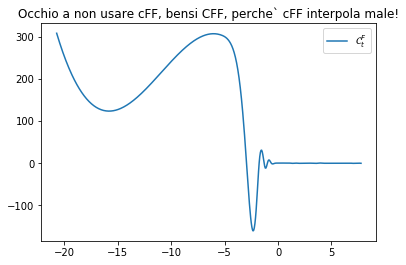

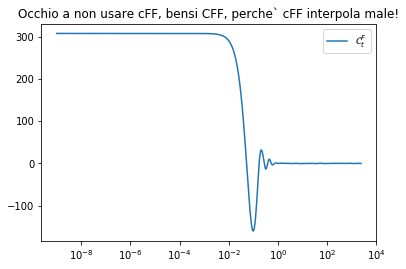

/usr/local/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (20) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/miniconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


it: 0  err =  31391.95455088599


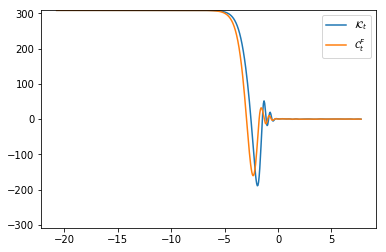

it: 1  err =  3064.5887860211647


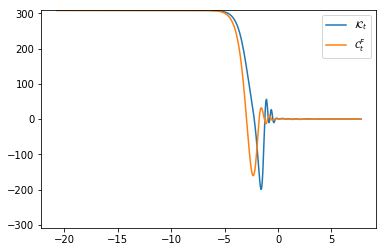

it: 2  err =  2568.2183339690937


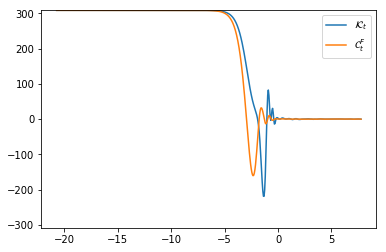

it: 3  err =  2383.561432086901


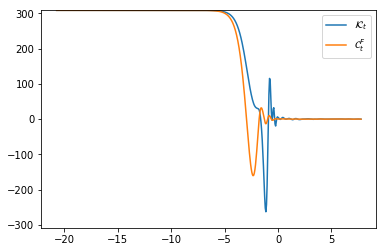

it: 4  err =  2355.512642157641


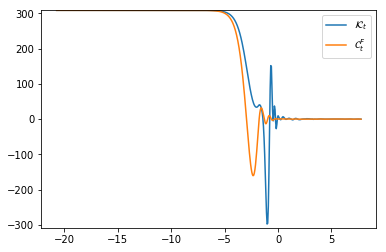

it: 5  err =  2369.9471927008444


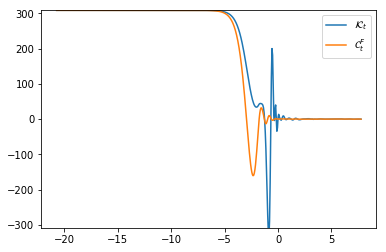

it: 6  err =  2489.5258640840852


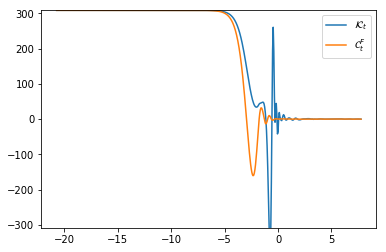

it: 7  err =  2651.069537226309


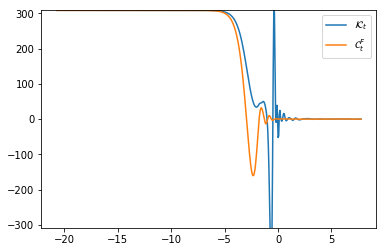

it: 8  err =  2772.0892441487254


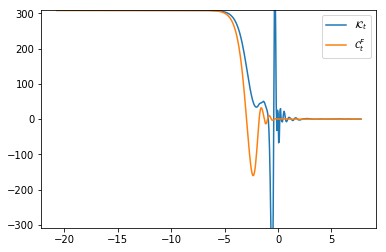

it: 9  err =  3089.8863473878673


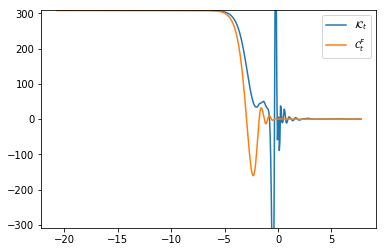

it: 10  err =  3452.750925522581


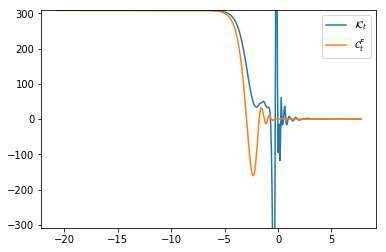

it: 11  err =  3883.8446365188906


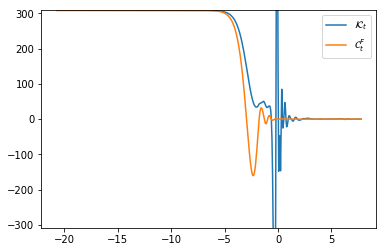

it: 12  err =  4268.430666953976


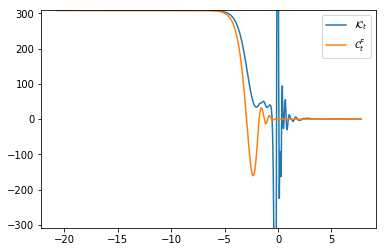

it: 13  err =  4702.214079919726


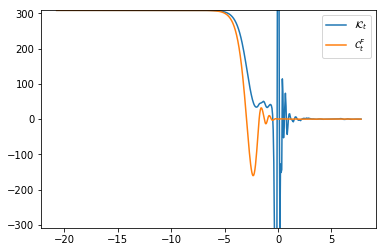

it: 14  err =  5299.076707896377


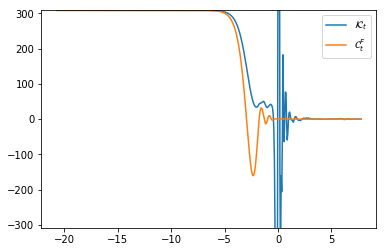

it: 15  err =  5826.914491431819


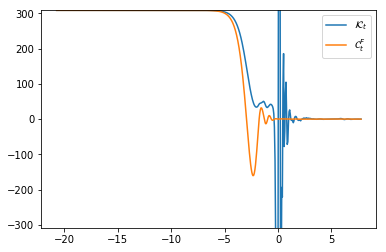

it: 16  err =  6762.4622203105255


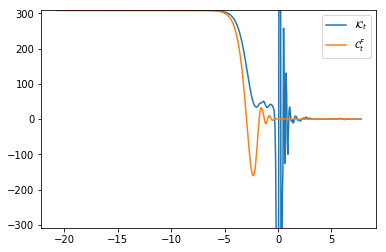

it: 17  err =  7623.518736942882


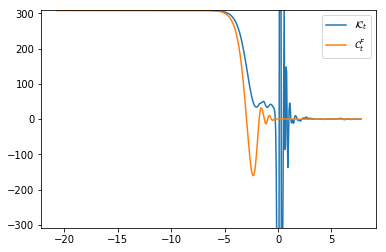

it: 18  err =  8799.913745574222


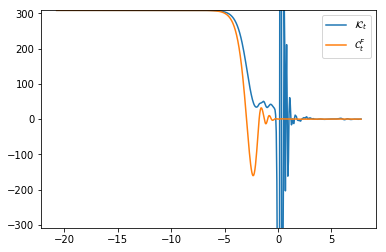

it: 19  err =  10306.324690549536


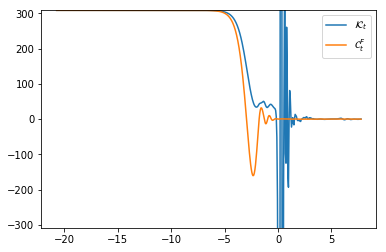

it: 20  err =  11438.306225040167


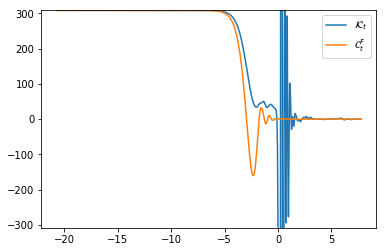

it: 21  err =  12566.90833146332


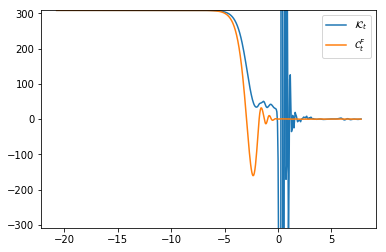

it: 22  err =  15861.42204050081


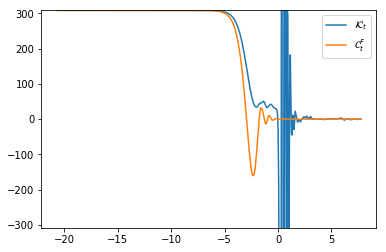

it: 23  err =  16650.77094959933


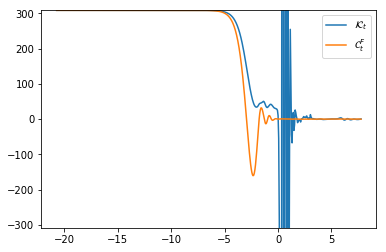

it: 24  err =  20826.39255611329


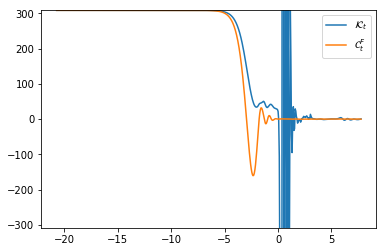

it: 25  err =  23412.346221917058


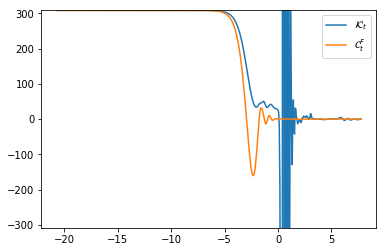

it: 26  err =  27667.89866856133


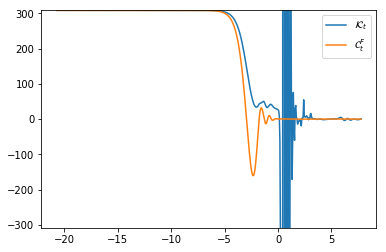

it: 27  err =  31553.564576582317


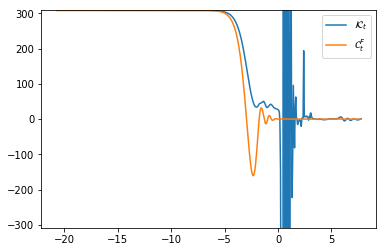

it: 28  err =  38797.67396012264


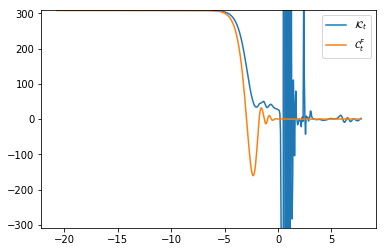

it: 29  err =  39729.710410563595


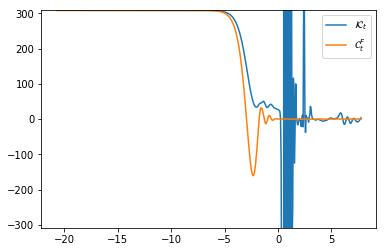

it: 30  err =  52225.438794875125


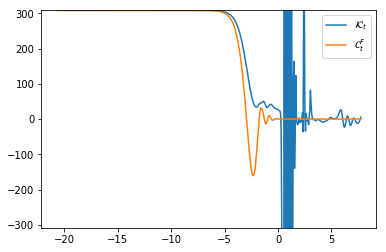

it: 31  err =  49320.645797443336


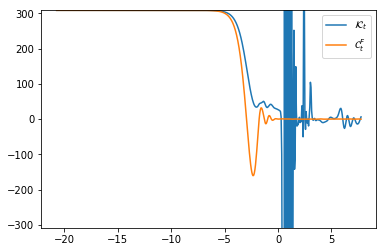

it: 32  err =  67529.67942232087


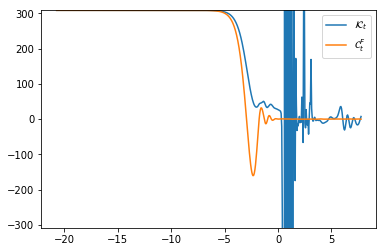

it: 33  err =  69648.80072034009


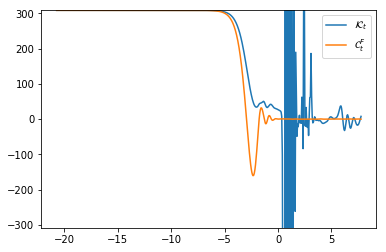

it: 34  err =  80692.2475782146


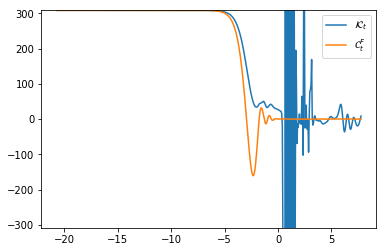

it: 35  err =  96568.11887785188


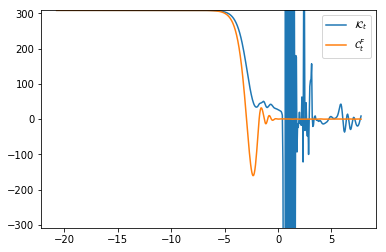

it: 36  err =  95602.60398758377


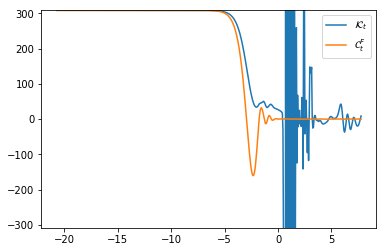

it: 37  err =  118807.94377570195


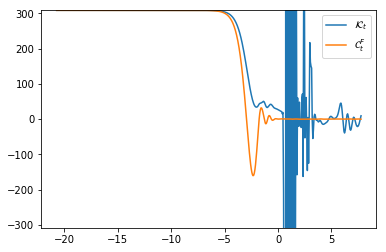

it: 38  err =  129930.06763189794


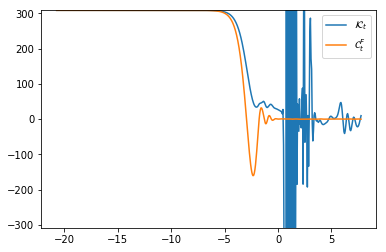

it: 39  err =  137327.51445079205


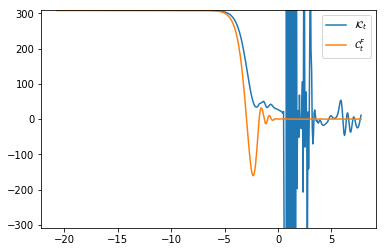

it: 40  err =  160118.66399484183


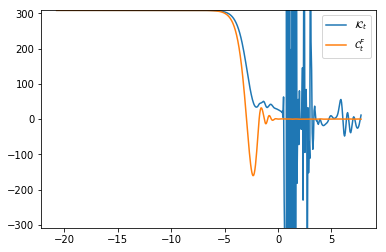

it: 41  err =  176904.4166209958


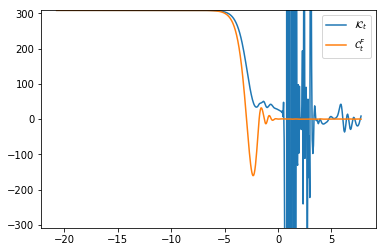

it: 42  err =  196267.9767388007


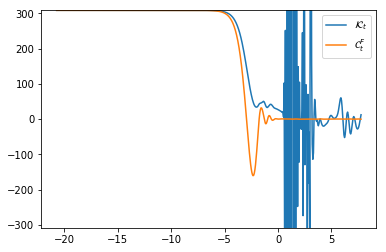

it: 43  err =  220462.53586559728


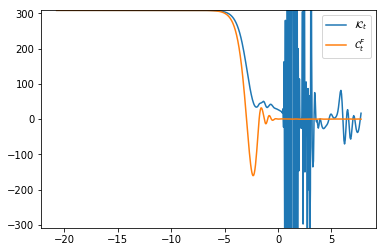

it: 44  err =  245977.4586932381


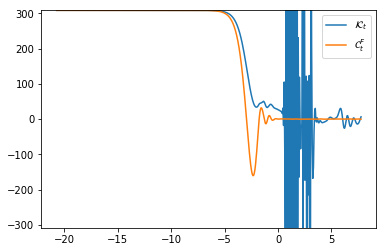

it: 45  err =  268460.5667937119


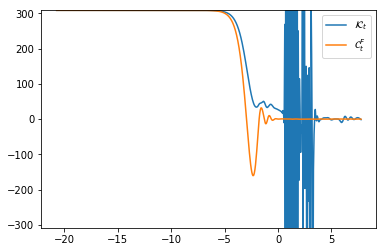

it: 46  err =  299714.62439736165


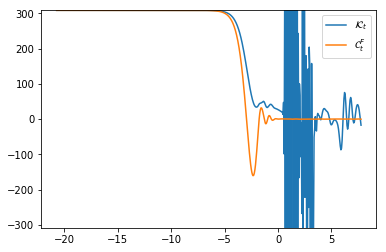

it: 47  err =  329759.850311437


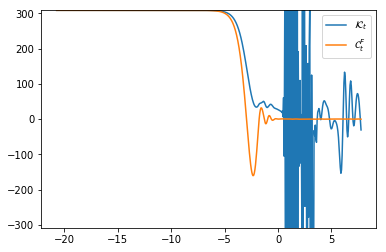

it: 48  err =  368403.50715782144


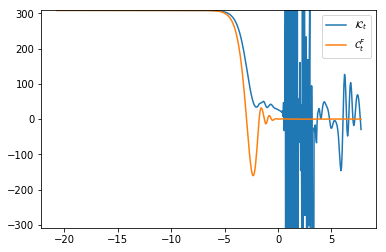

it: 49  err =  411340.91996550414


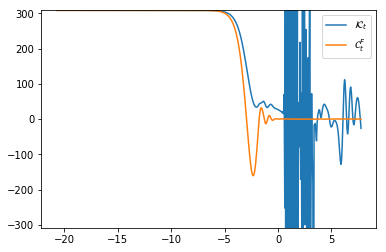

it: 50  err =  458829.2803969321


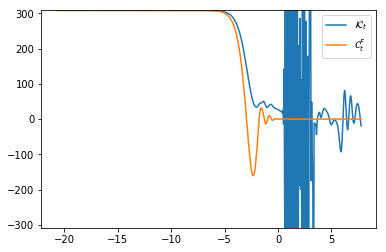

it: 51  err =  517912.4553940283


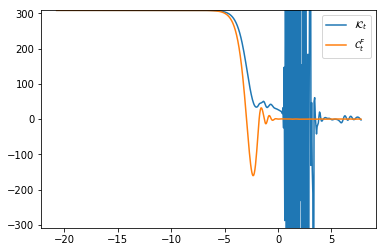

it: 52  err =  564026.690032241


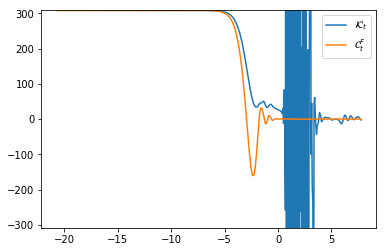

it: 53  err =  640422.7276643056


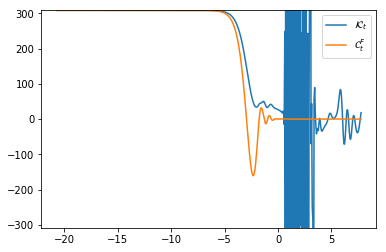

it: 54  err =  685150.2704130934


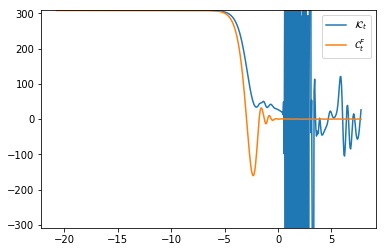

it: 55  err =  806008.3746824954


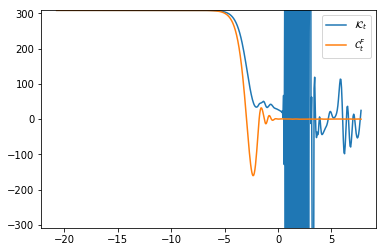

it: 56  err =  839212.0920517123


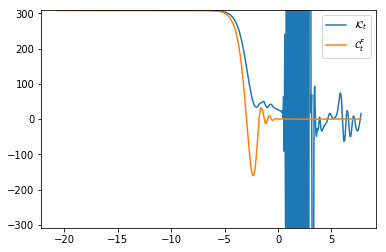

it: 57  err =  1003558.211931715


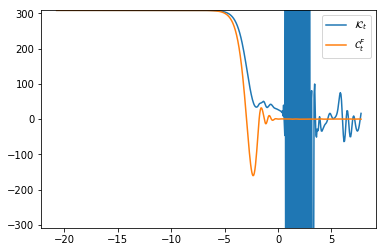

it: 58  err =  1073061.8302647478


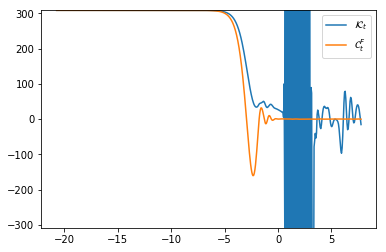

it: 59  err =  1221159.2010332993


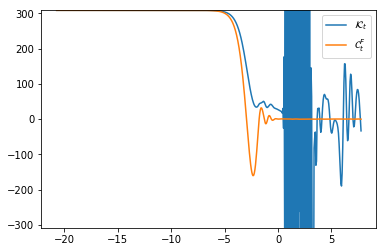

it: 60  err =  1365334.1526706002


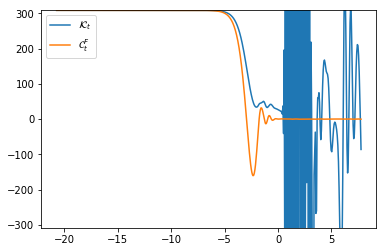

it: 61  err =  1418924.7861939399


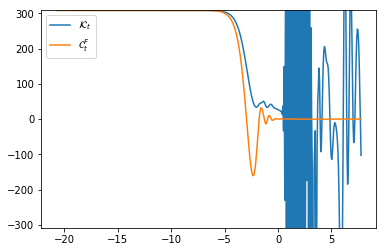

it: 62  err =  1716778.8815696756


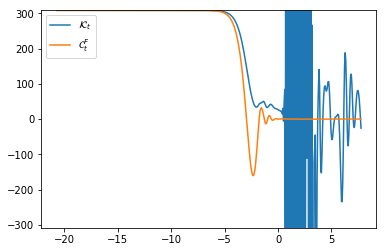

it: 63  err =  1810662.0090593656


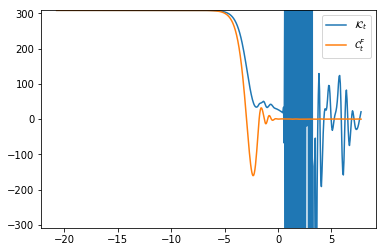

it: 64  err =  2004517.6154801487


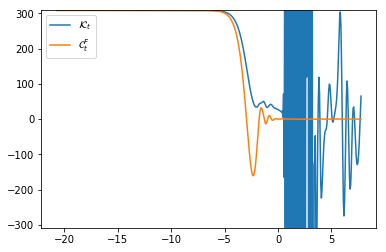

it: 65  err =  2311911.4200255177


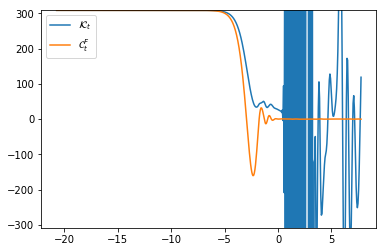

it: 66  err =  2425199.871312564


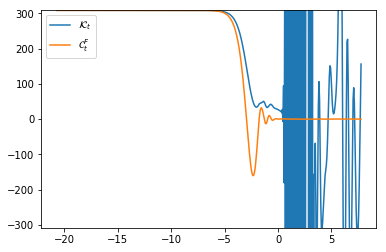

it: 67  err =  2739249.9593647313


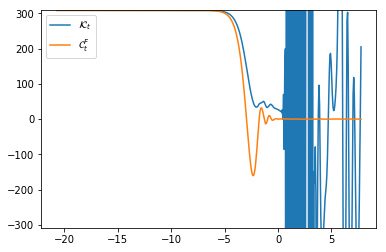

it: 68  err =  3119600.801811545


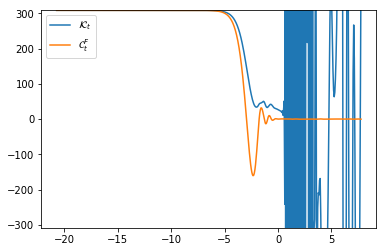

it: 69  err =  3324945.1283059716


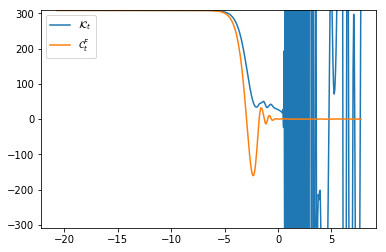

it: 70  err =  3636904.093287924


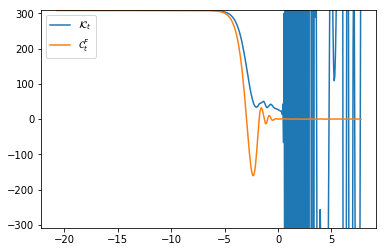

it: 71  err =  4096651.469888297


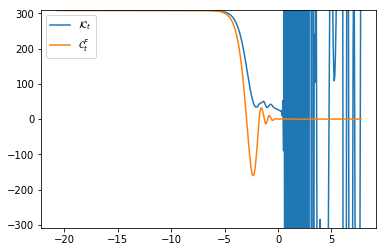

it: 72  err =  4370562.919118414


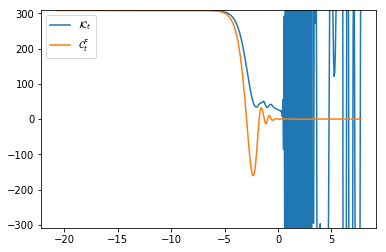

it: 73  err =  4812915.372005334


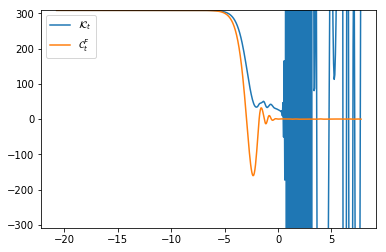

it: 74  err =  5295473.214949019


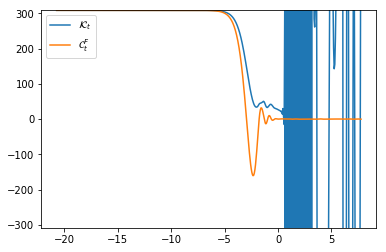

it: 75  err =  5942240.021297202


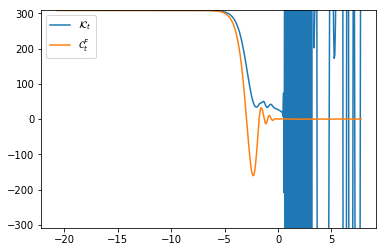

it: 76  err =  6301893.5630175


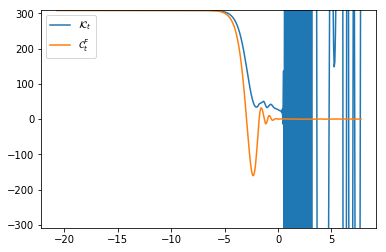

it: 77  err =  6978440.39759242


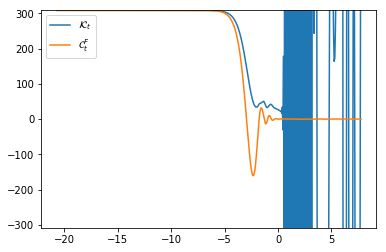

it: 78  err =  7636507.877038355


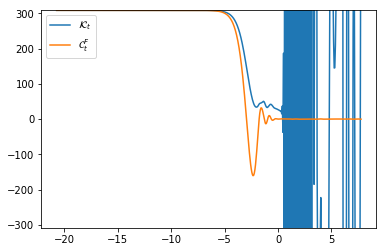

it: 79  err =  8408541.925640518


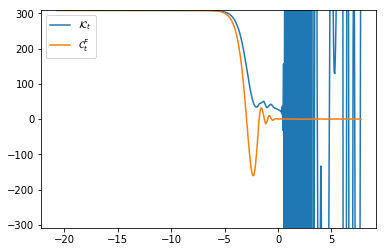

it: 80  err =  8889992.195695138


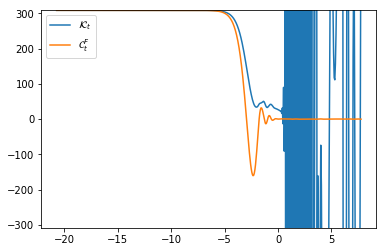

it: 81  err =  10022254.104402231


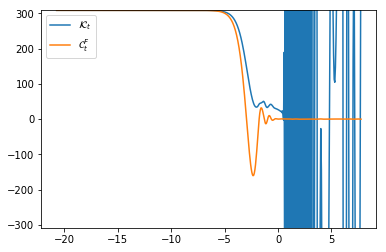

it: 82  err =  10787893.992013395


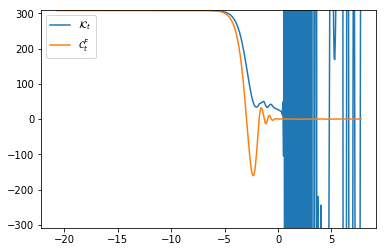

it: 83  err =  11716075.798559943


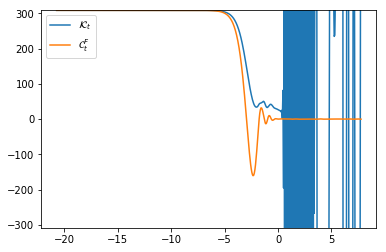

it: 84  err =  13155872.825867817


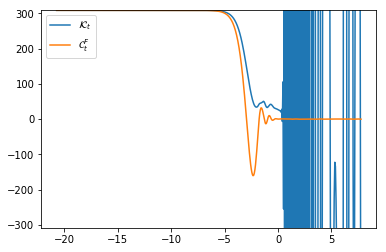

it: 85  err =  13544185.703517828


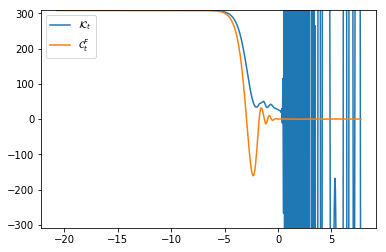

it: 86  err =  14977058.362086965


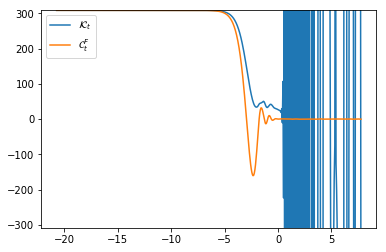

it: 87  err =  16330004.49452533


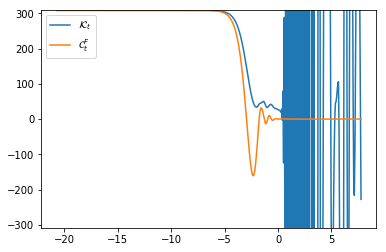

it: 88  err =  16971264.031567432


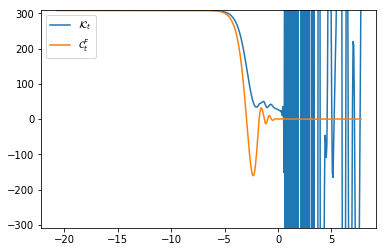

it: 89  err =  19148205.775750577


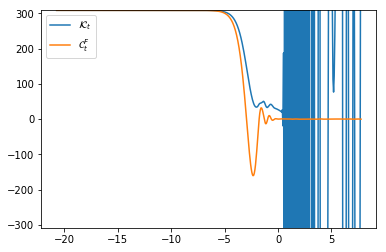

it: 90  err =  20475097.500926834


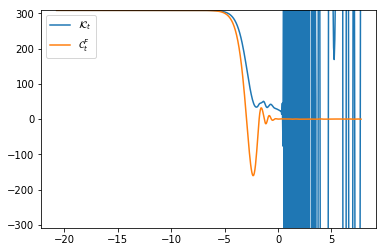

it: 91  err =  21655844.68581932


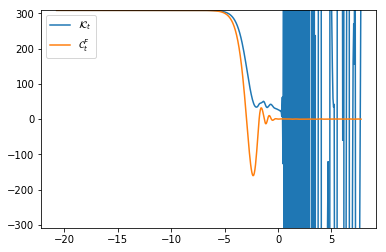

it: 92  err =  24132565.09095563


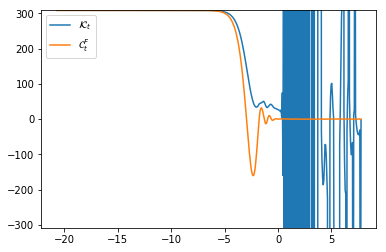

it: 93  err =  26113080.089194346


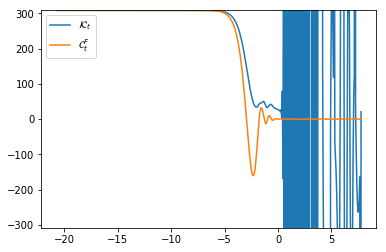

it: 94  err =  27585016.83138627


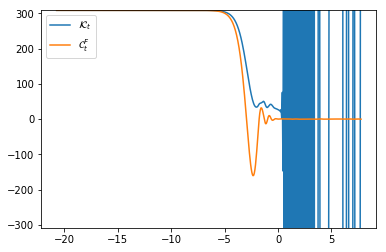

it: 95  err =  30086562.250373445


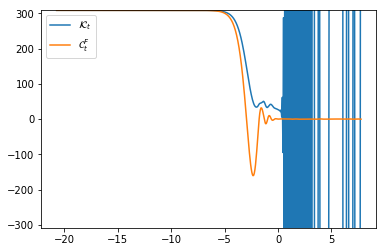

it: 96  err =  31333908.41363383


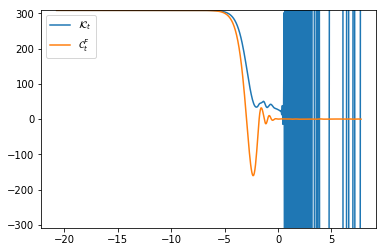

it: 97  err =  34104153.151036225


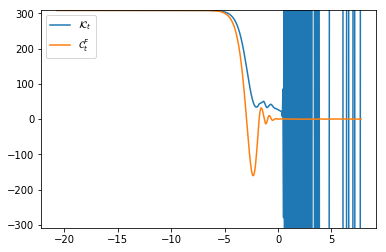

it: 98  err =  36110677.72422319


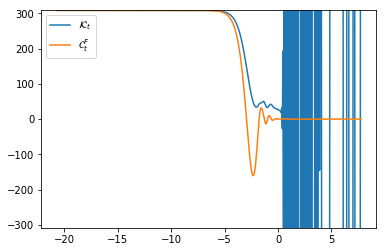

it: 99  err =  39241753.74915812


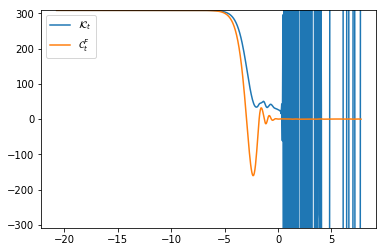

it: 100  err =  41333430.44047661


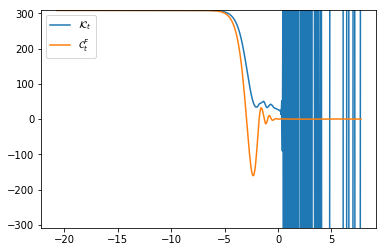

it: 101  err =  44986276.99710235


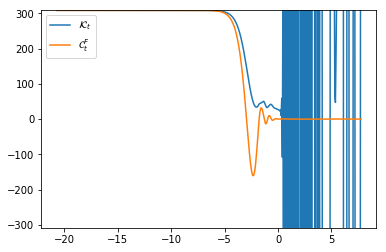

it: 102  err =  47246475.205497734


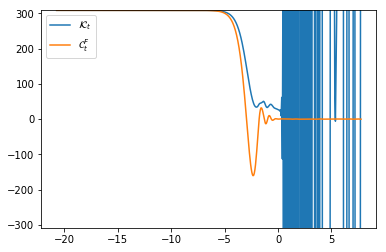

it: 103  err =  50512496.9977857


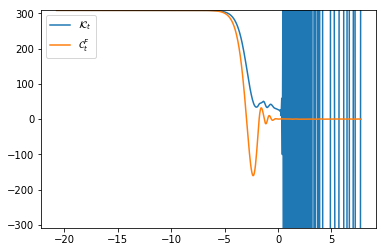

it: 104  err =  60378960.549575105


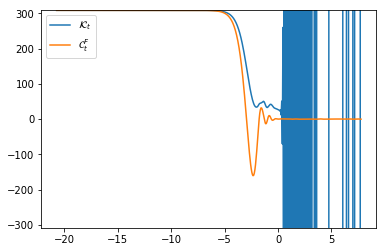

it: 105  err =  60538885.46119793


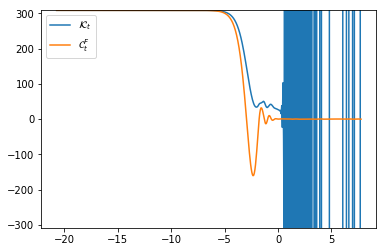

it: 106  err =  69171822.43747059


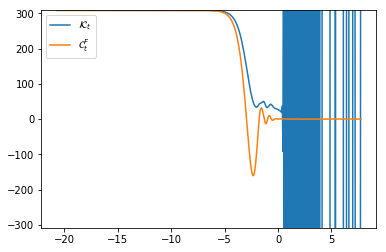

it: 107  err =  67640172.54519442


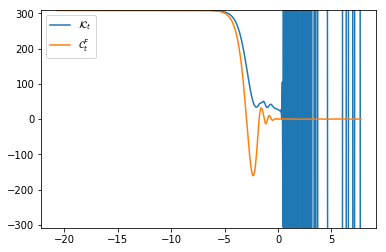

it: 108  err =  71816940.02646005


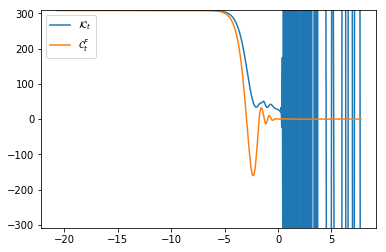

it: 109  err =  76333814.51378419


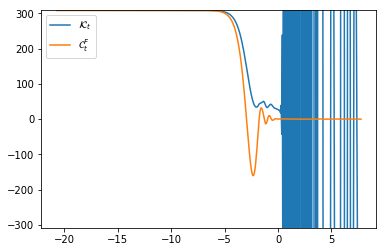

it: 110  err =  80430601.23122755


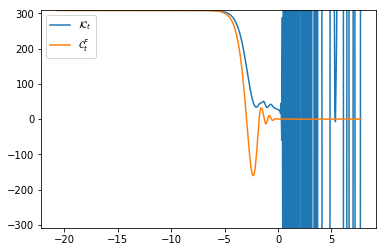

it: 111  err =  86701654.05501163


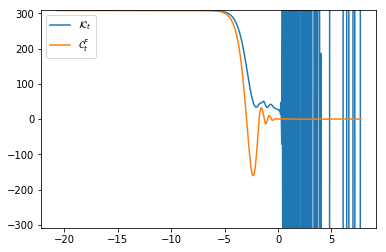

it: 112  err =  93551498.45487589


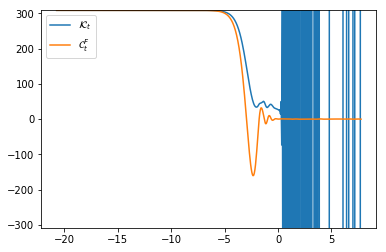

it: 113  err =  98218900.39897075


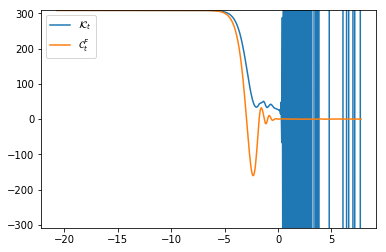

it: 114  err =  106864918.6118139


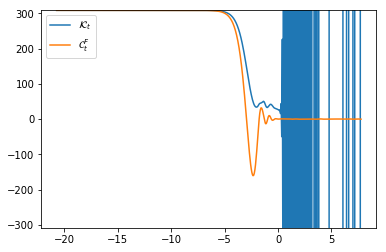

it: 115  err =  112299735.12693512


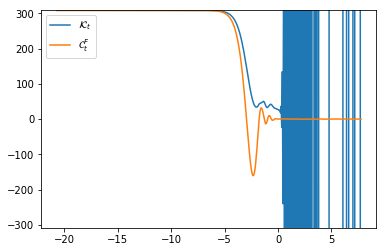

it: 116  err =  122575224.7480008


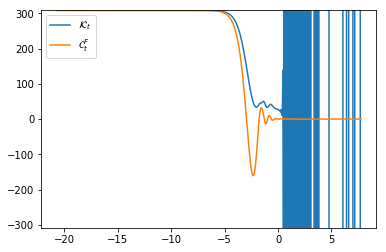

it: 117  err =  132081710.73582456


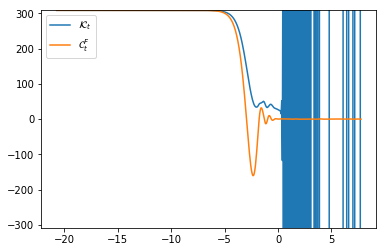

it: 118  err =  138186027.2433648


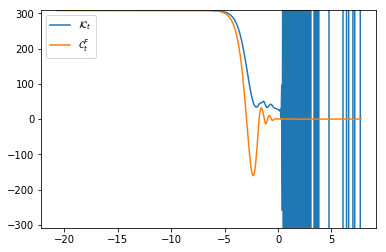

it: 119  err =  146303226.88365328


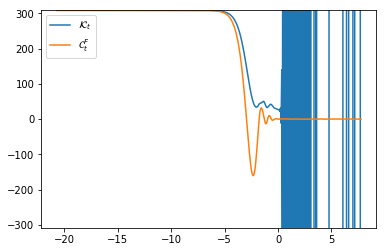

it: 120  err =  154128103.30577007


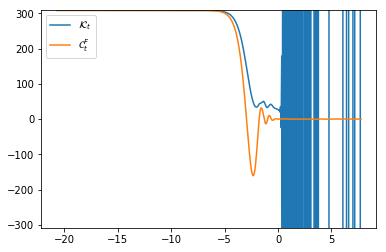

it: 121  err =  167529885.9835084


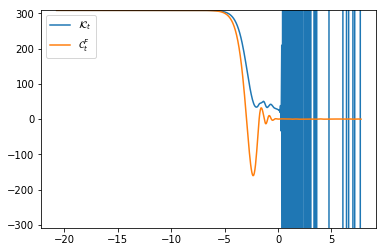

it: 122  err =  181469383.03683096


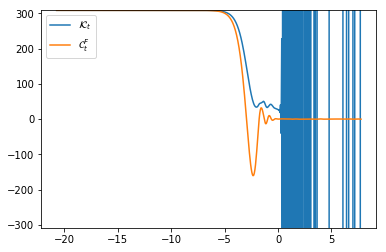

it: 123  err =  184308724.8347651


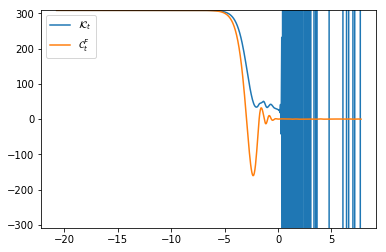

it: 124  err =  201426949.21641445


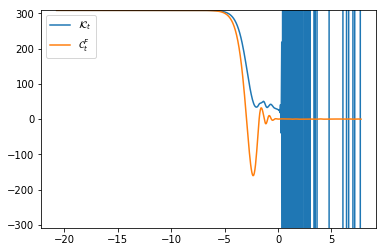

it: 125  err =  223604424.248072


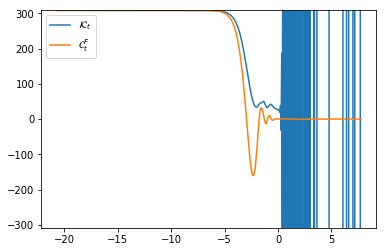

it: 126  err =  229988962.50241372


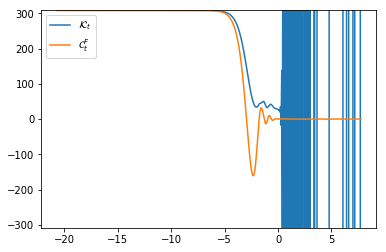

it: 127  err =  243033205.9001446


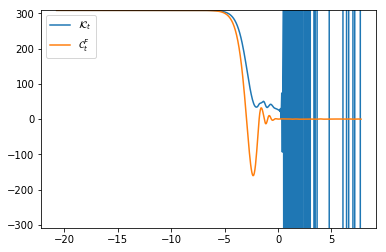

it: 128  err =  252940904.45056522


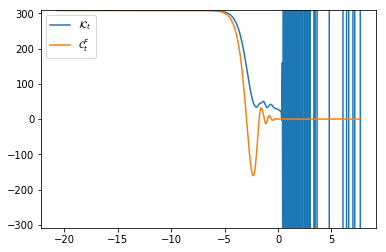

it: 129  err =  277670079.8314958


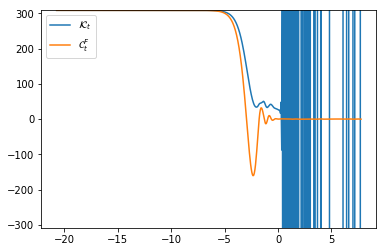

it: 130  err =  370284598.4807954


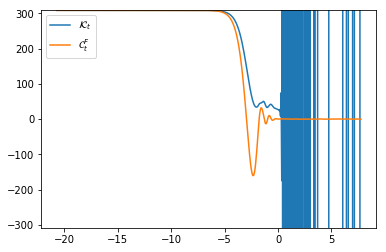

it: 131  err =  401817344.67917573


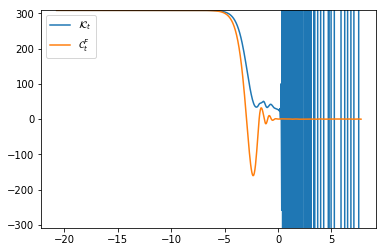

it: 132  err =  374314882.7244453


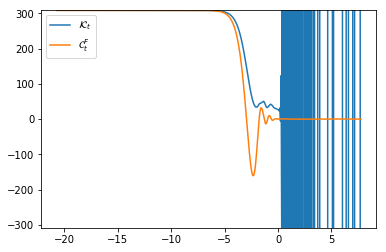

it: 133  err =  367751590.3952954


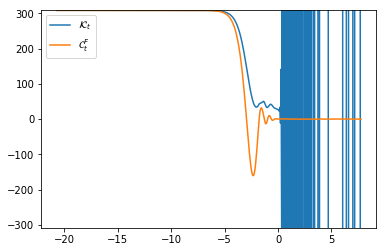

it: 134  err =  355104499.17893636


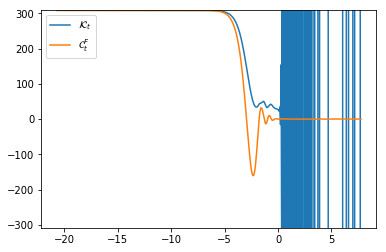

it: 135  err =  379653520.24082613


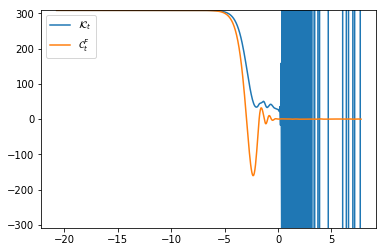

it: 136  err =  404364967.09860533


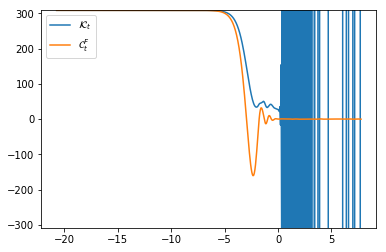

it: 137  err =  440222826.76124364


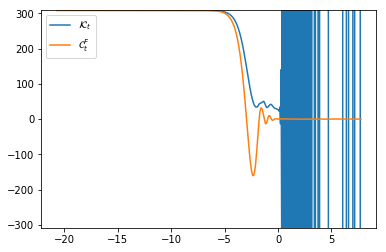

it: 138  err =  467271197.9323736


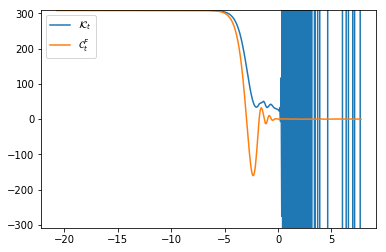

it: 139  err =  484334816.40476274


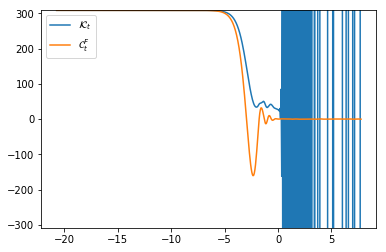

it: 140  err =  521765249.1102222


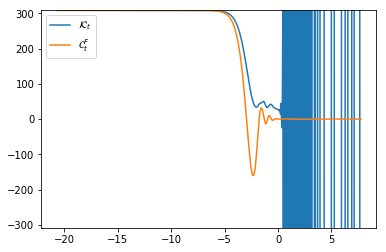

it: 141  err =  563914497.3435564


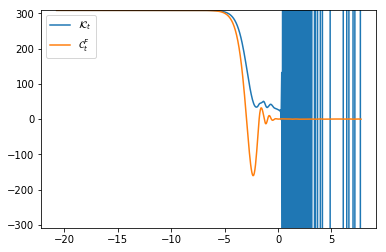

it: 142  err =  601680523.3097719


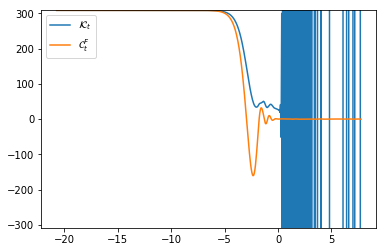

it: 143  err =  631444128.78419


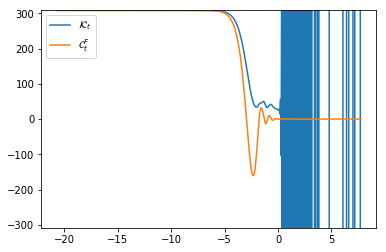

it: 144  err =  667217799.5228918


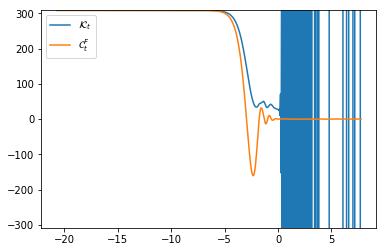

it: 145  err =  715677564.9098693


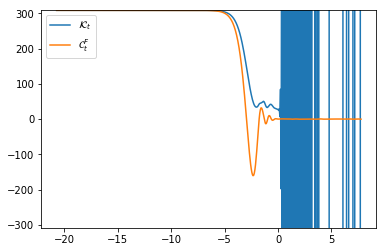

it: 146  err =  763390238.0187502


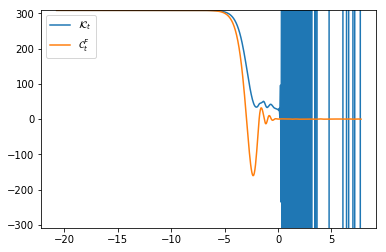

it: 147  err =  799041626.2208289


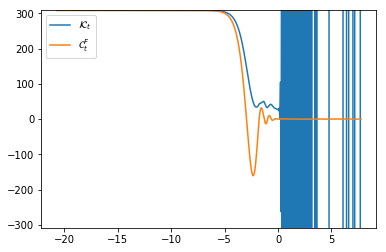

it: 148  err =  977736526.1852823


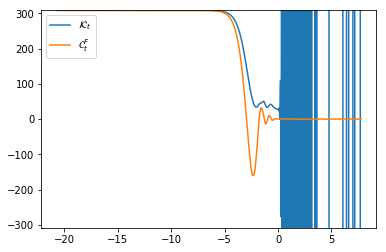

it: 149  err =  1134777072.592034


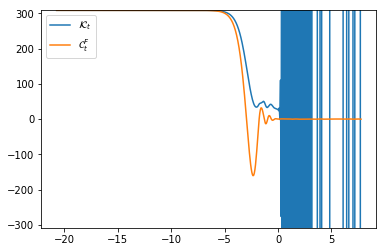

it: 150  err =  1316051029.9365556


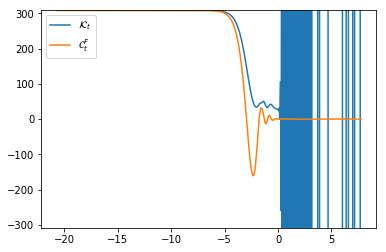

it: 151  err =  1463241831.4368677


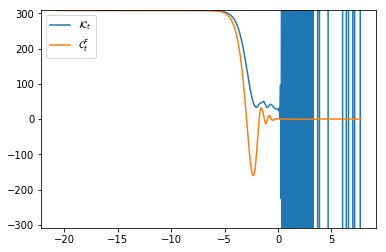

it: 152  err =  1711773922.9107645


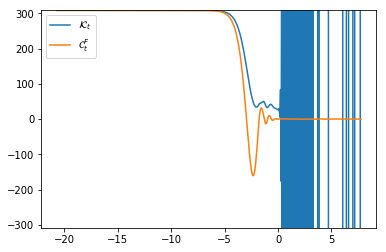

it: 153  err =  2170530163.5566864


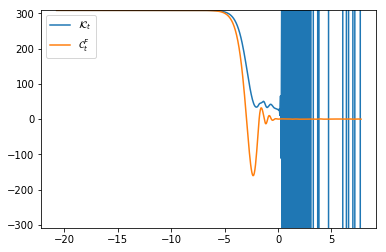

it: 154  err =  2470627150.9841714


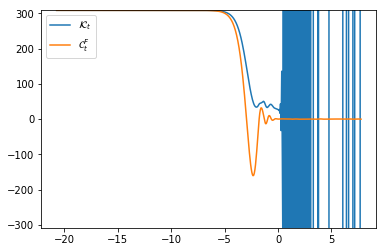

it: 155  err =  2726076952.160428


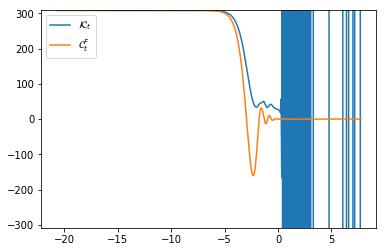

it: 156  err =  3217662700.4496455


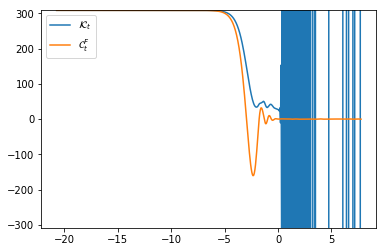

it: 157  err =  3772765631.6656733


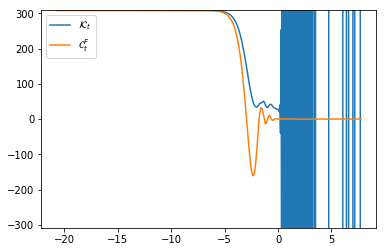

it: 158  err =  3953942375.479605


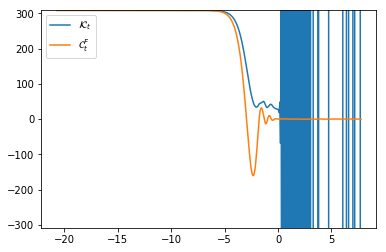

it: 159  err =  5198915392.067103


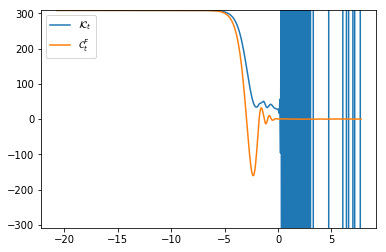

it: 160  err =  6305343602.556624


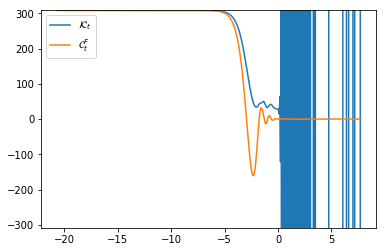

it: 161  err =  7539887807.799785


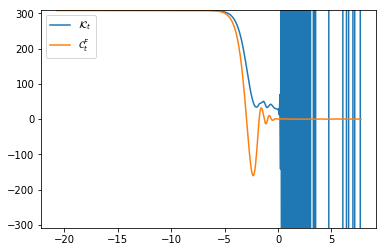

it: 162  err =  9536322598.841242


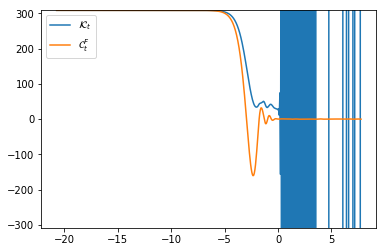

it: 163  err =  9548203706.050566


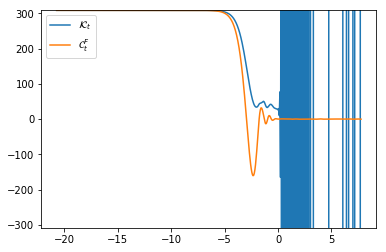

it: 164  err =  13261795819.113176


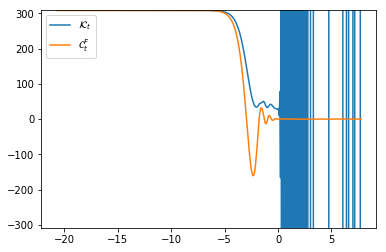

it: 165  err =  16742912120.67942


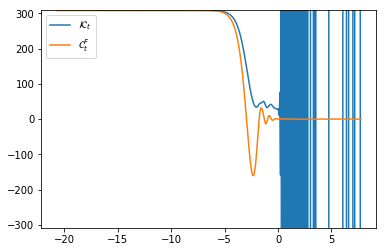

it: 166  err =  19486545300.36443


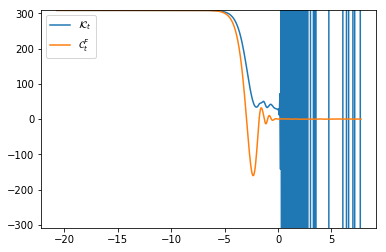

it: 167  err =  25438360150.9915


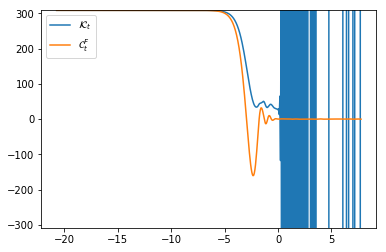

it: 168  err =  25659609847.33511


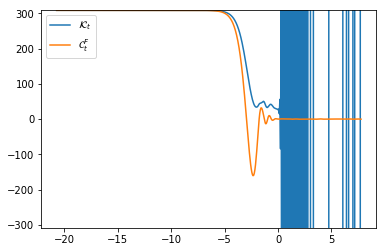

it: 169  err =  38037479288.58979


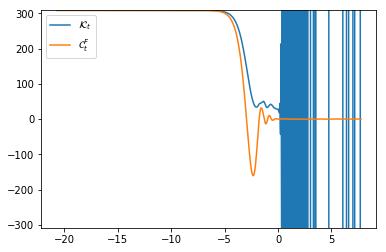

it: 170  err =  43975232768.32458


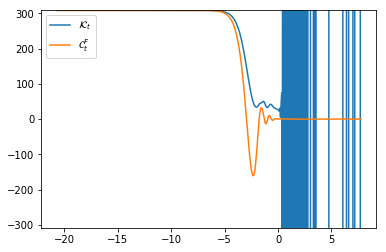

it: 171  err =  56053360106.44038


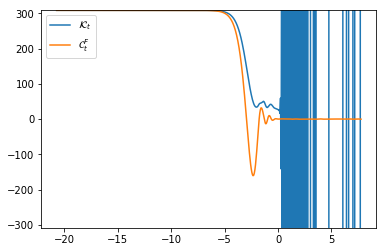

it: 172  err =  71994304303.49759


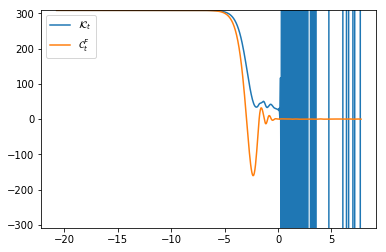

it: 173  err =  74450209742.13562


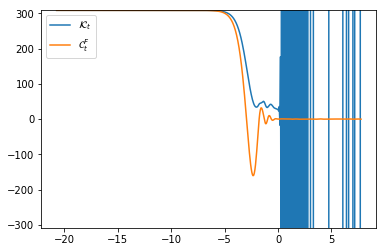

it: 174  err =  99020945089.21834


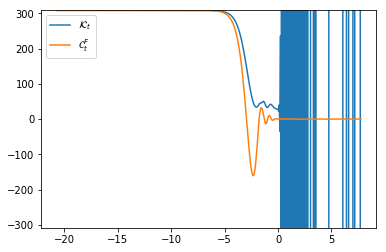

it: 175  err =  124520948180.77142


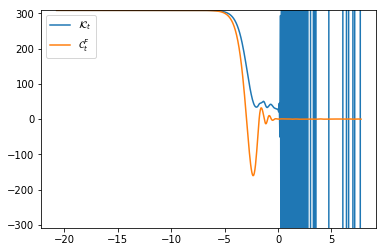

it: 176  err =  153454466669.81625


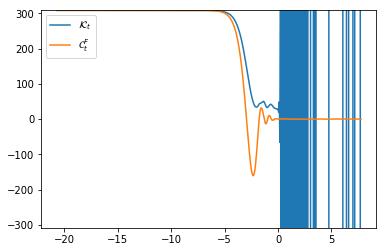

it: 177  err =  208955148240.31082


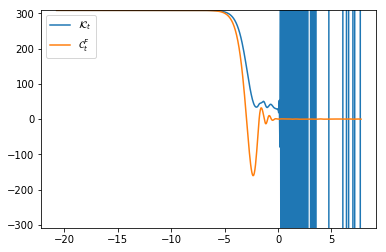

it: 178  err =  199792265539.1794


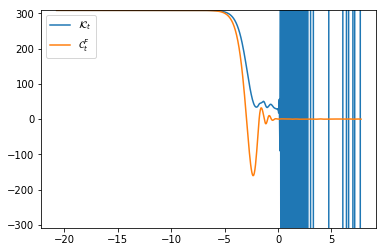

it: 179  err =  293129932166.60803


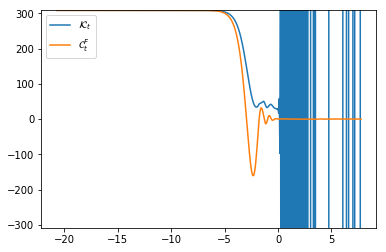

it: 180  err =  377880251816.88696


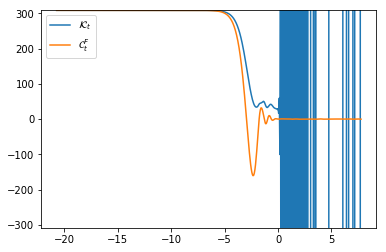

it: 181  err =  433467284186.2415


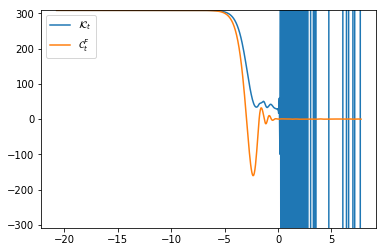

it: 182  err =  597729859048.4661


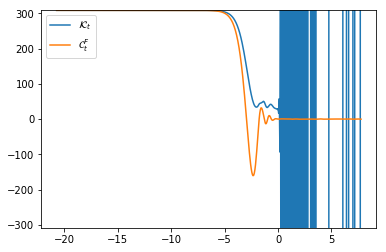

it: 183  err =  594298607428.8069


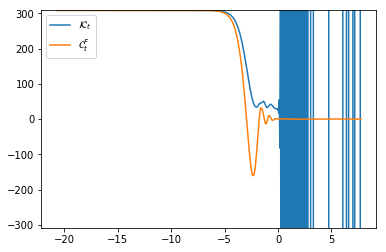

it: 184  err =  647798588805.7395


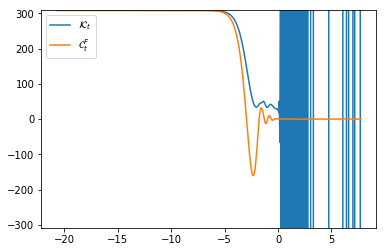

it: 185  err =  458660961337.08813


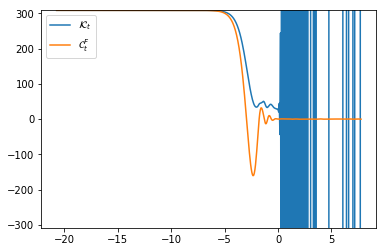

it: 186  err =  559901886141.0007


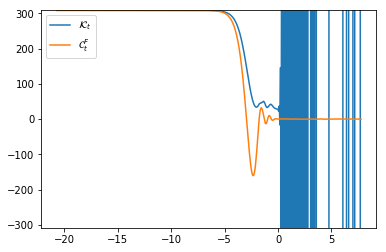

it: 187  err =  530370847401.35767


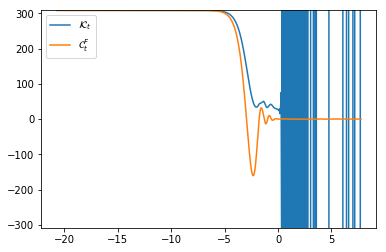

it: 188  err =  581547839613.112


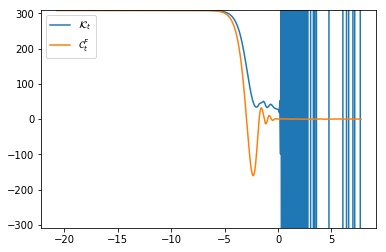

it: 189  err =  608580922899.6868


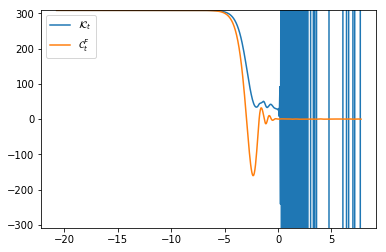

it: 190  err =  663347460174.6348


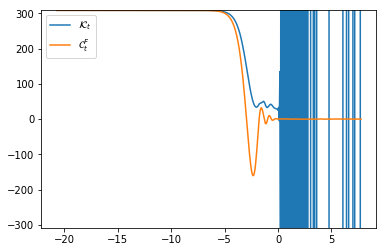

it: 191  err =  808317278933.44


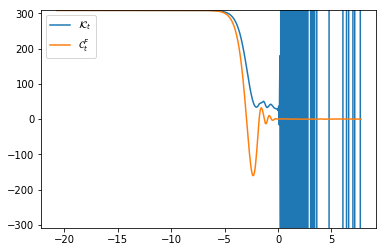

it: 192  err =  830526112352.0833


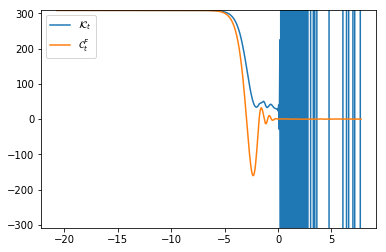

it: 193  err =  855656584829.2617


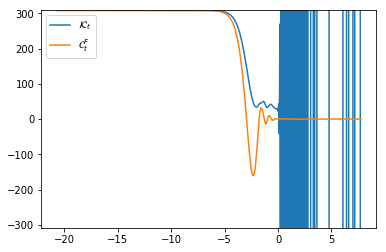

it: 194  err =  890986650414.3136


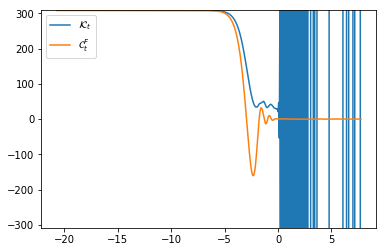

it: 195  err =  956834742634.2266


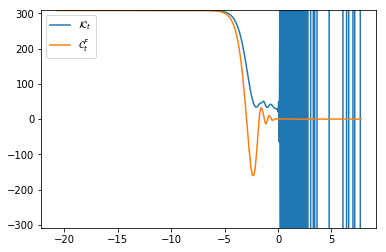

it: 196  err =  1042809946020.7401


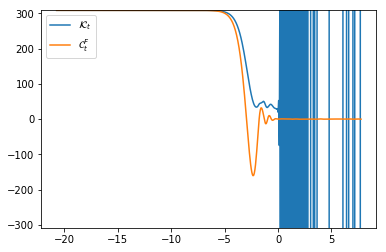

it: 197  err =  1125861160806.2346


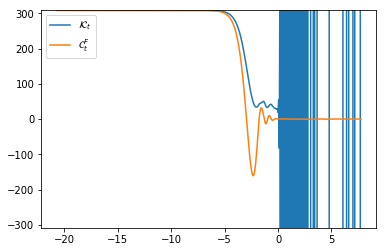

it: 198  err =  1224720466787.8657


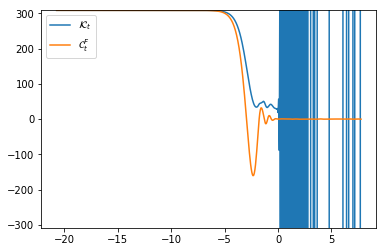

it: 199  err =  1553590116164.9814


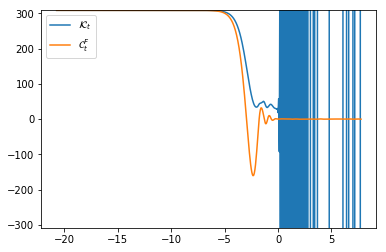

it: 200  err =  1812109080224.0298


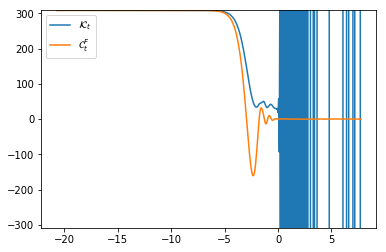

it: 201  err =  1644942232288.3171


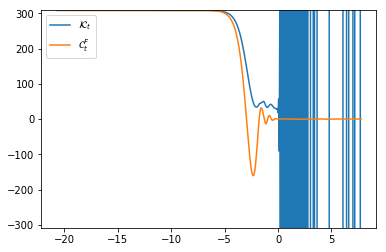

it: 202  err =  2103427914635.2178


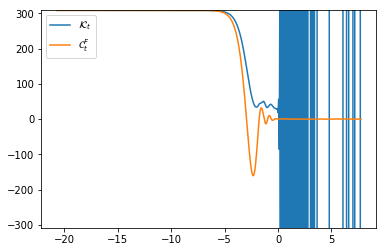

it: 203  err =  2401708458318.2847


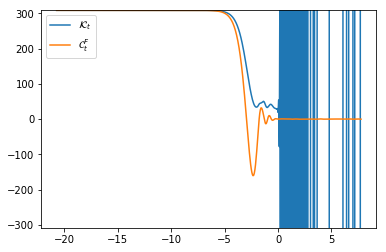

it: 204  err =  2286515963944.0303


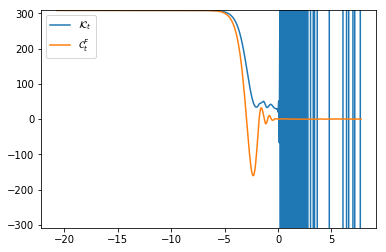

it: 205  err =  2326819552430.028


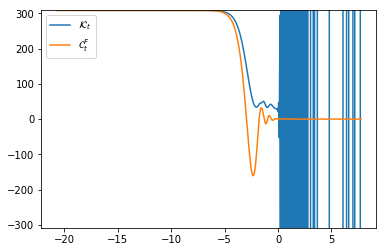

it: 206  err =  2589142982635.0903


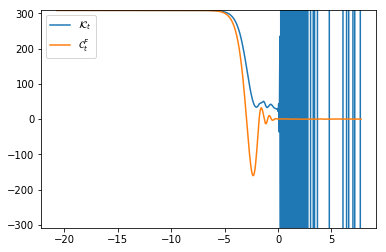

it: 207  err =  2812302629900.6787


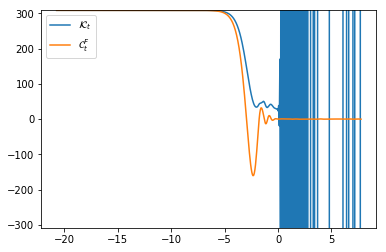

it: 208  err =  3571987578403.795


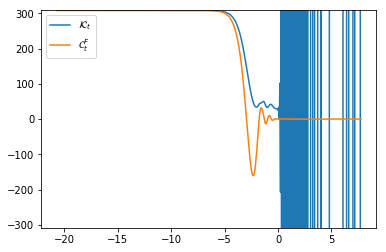

it: 209  err =  4075406627879.5


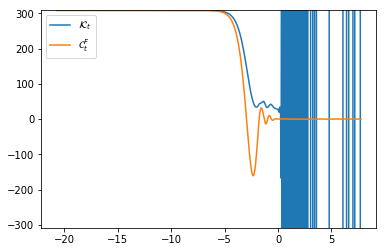

it: 210  err =  3902609906722.013


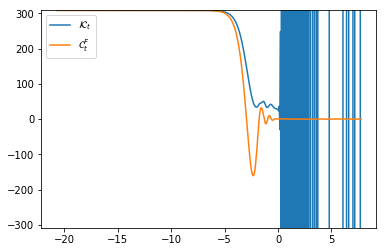

it: 211  err =  4174385974104.7363


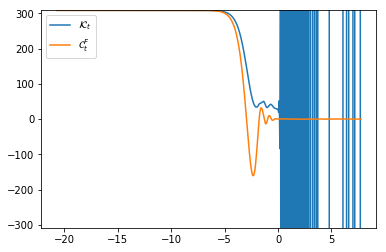

it: 212  err =  4594553099804.321


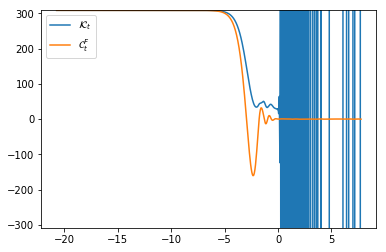

it: 213  err =  5872140042707.17


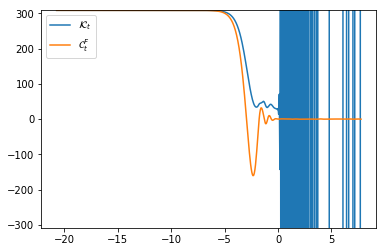

it: 214  err =  6676106274043.232


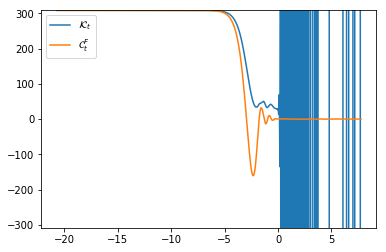

it: 215  err =  7163659277543.888


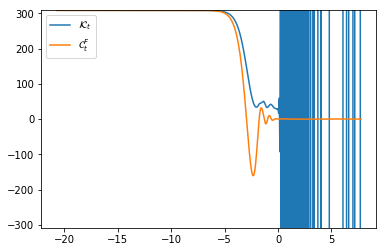

it: 216  err =  7059278662306.793


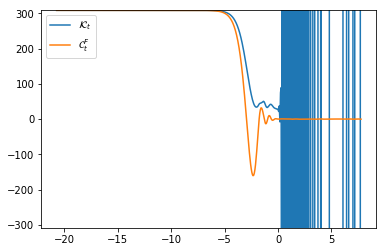

it: 217  err =  7827994272718.502


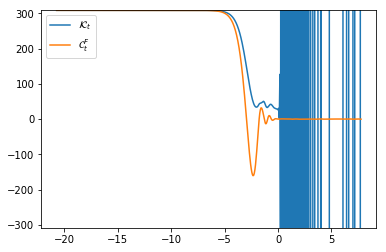

it: 218  err =  8594807733350.996


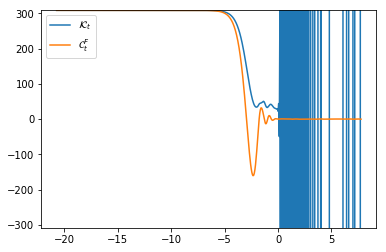

it: 219  err =  9913116696565.51


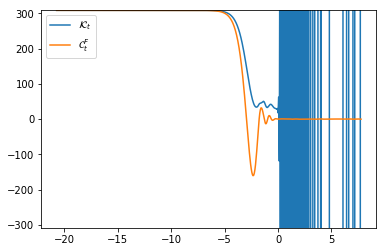

it: 220  err =  10794948374137.332


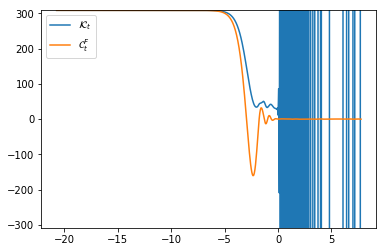

it: 221  err =  12006524545637.488


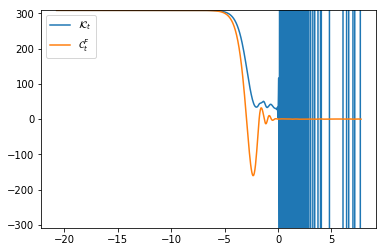

it: 222  err =  13472012573198.684


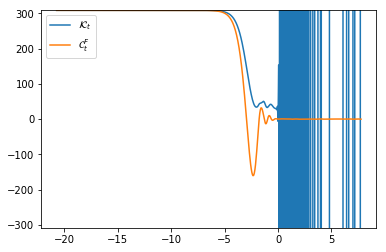

it: 223  err =  14923130085717.492


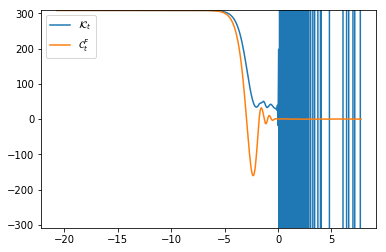

it: 224  err =  16975334012139.008


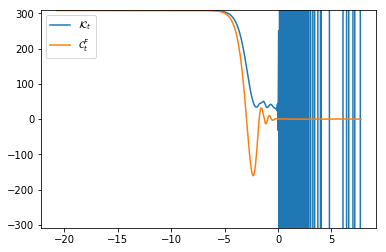

it: 225  err =  18686691696206.484


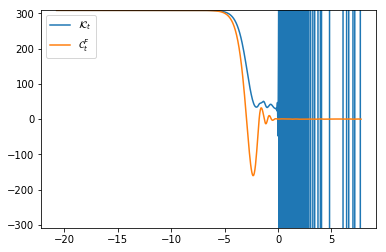

it: 226  err =  20285088268713.45


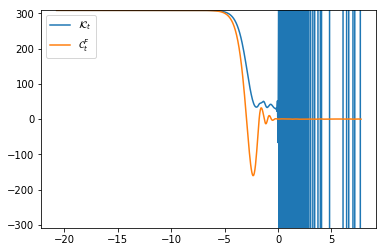

it: 227  err =  23234327453576.383


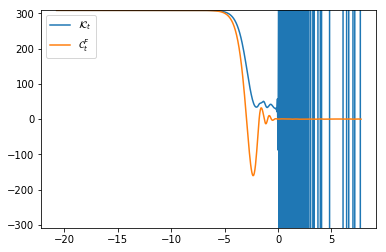

it: 228  err =  26568966997787.777


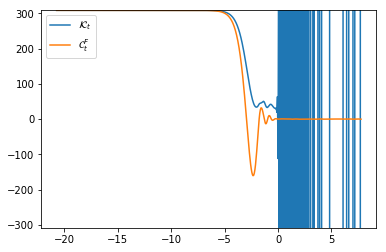

it: 229  err =  30029889170058.996


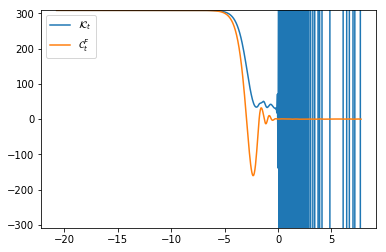

it: 230  err =  32756166844315.74


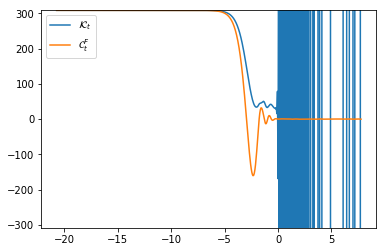

it: 231  err =  35630442087151.87


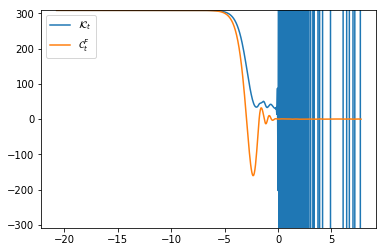

it: 232  err =  39499860176737.15


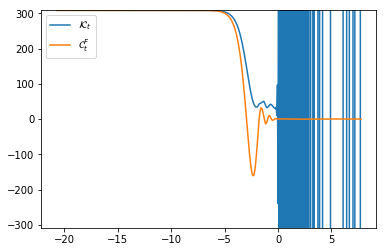

it: 233  err =  45722800048038.375


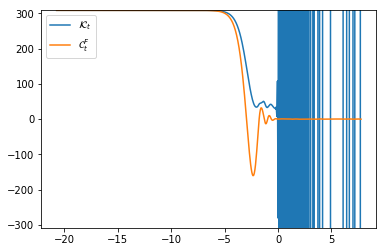

it: 234  err =  63255991925058.766


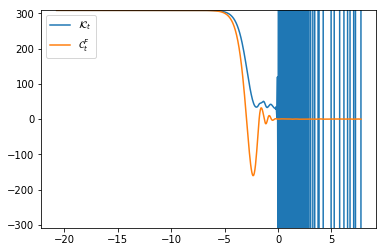

it: 235  err =  63503700576994.875


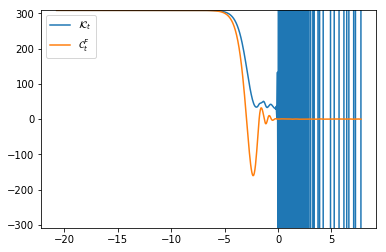

it: 236  err =  67678567296111.24


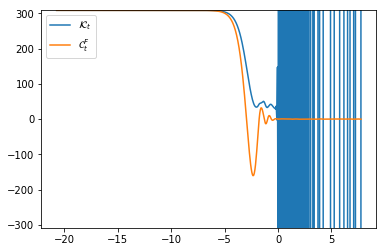

it: 237  err =  82996800965393.14


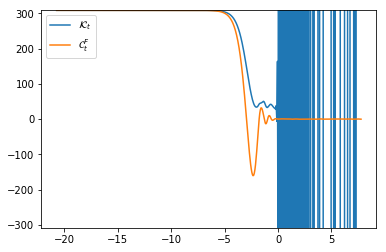

it: 238  err =  128083967214505.16


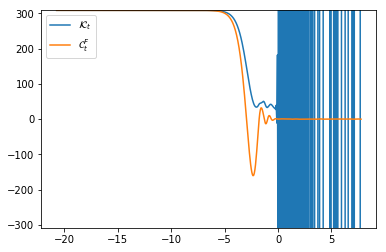

it: 239  err =  136287046940301.05


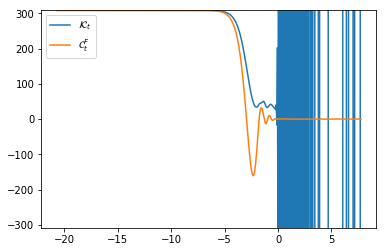

it: 240  err =  113533170924181.66


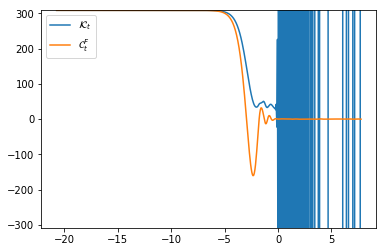

it: 241  err =  128786953090190.36


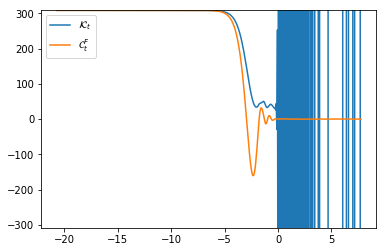

it: 242  err =  152963912896585.06


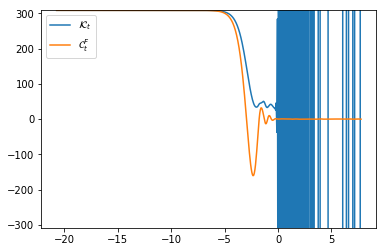

it: 243  err =  171765179447439.78


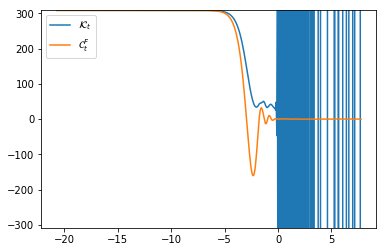

it: 244  err =  294868620284208.25


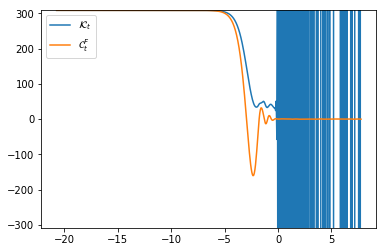

it: 245  err =  256214358662408.66


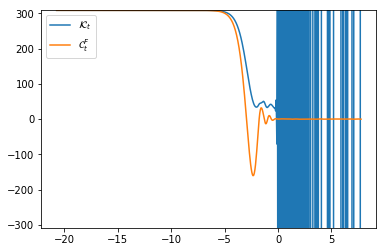

it: 246  err =  261058612303384.28


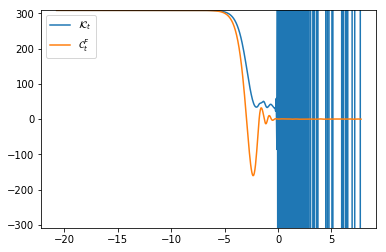

it: 247  err =  261405615655071.62


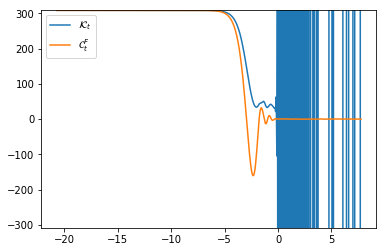

it: 248  err =  289493619652998.94


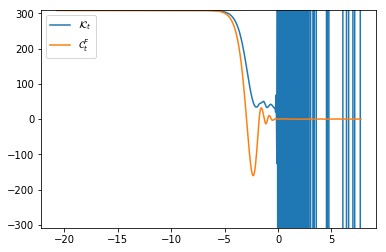

it: 249  err =  336839046139819.9


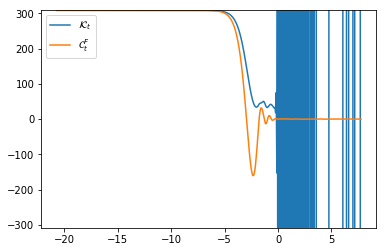

it: 250  err =  375246784715404.1


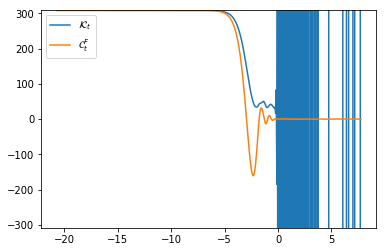

it: 251  err =  415947360033870.56


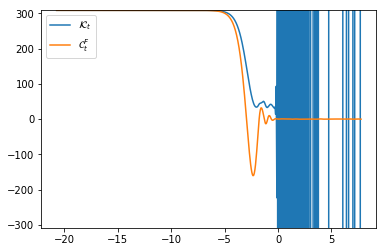

it: 252  err =  491849494225856.94


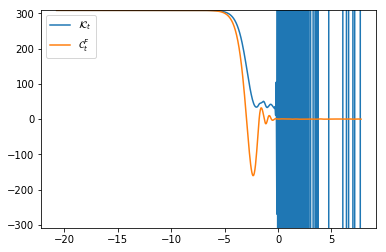

it: 253  err =  565891244887218.2


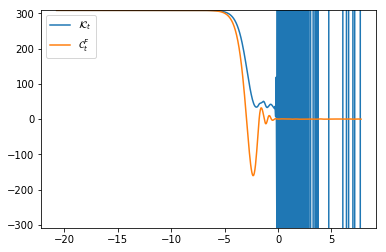

it: 254  err =  656733819117638.2


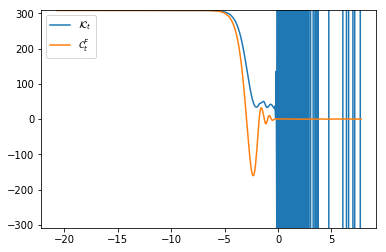

it: 255  err =  744828486027775.0


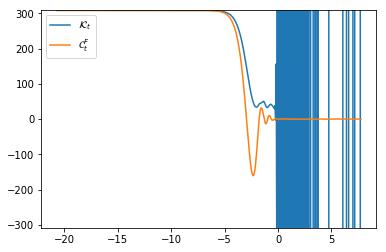

it: 256  err =  890417469819686.9


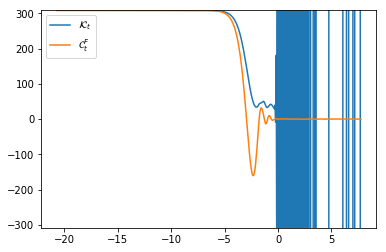

it: 257  err =  1065485410094908.5


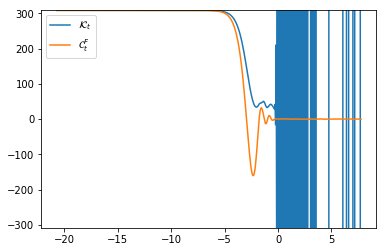

it: 258  err =  1109893049536263.5


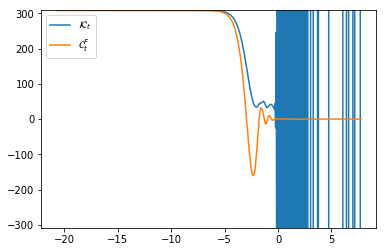

it: 259  err =  1401826782300041.8


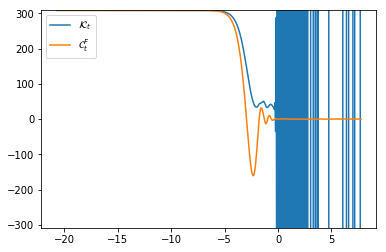

it: 260  err =  1614825918988480.8


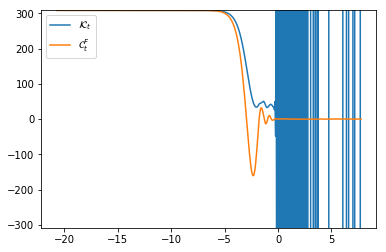

it: 261  err =  1968451441349703.2


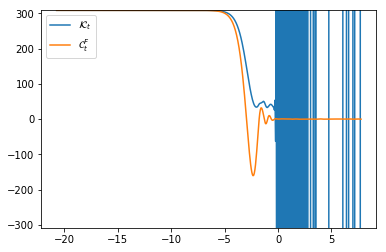

it: 262  err =  2343743084890468.0


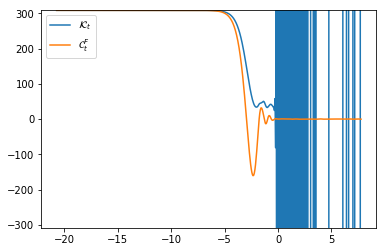

it: 263  err =  2702575607230441.0


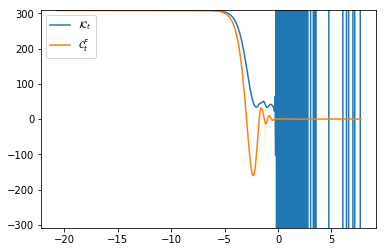

it: 264  err =  3384350211453253.0


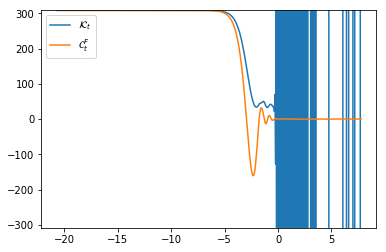

it: 265  err =  3432779230872779.0


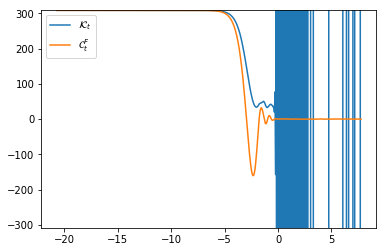

it: 266  err =  4545647170770262.0


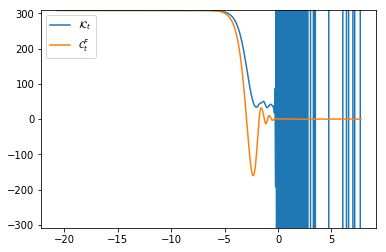

it: 267  err =  5406154315751319.0


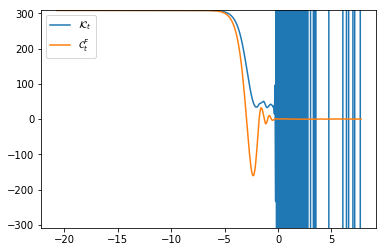

it: 268  err =  6310267831965674.0


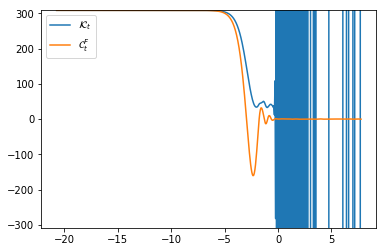

it: 269  err =  7514955218087322.0


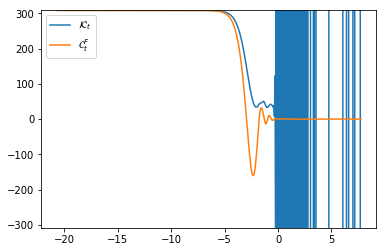

it: 270  err =  9477681810040526.0


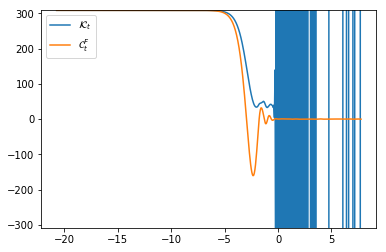

it: 271  err =  9631330980396914.0


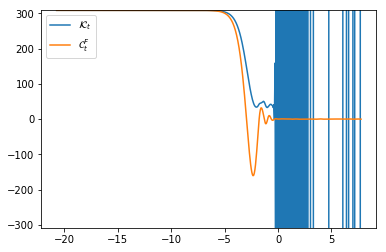

it: 272  err =  1.26467485228396e+16


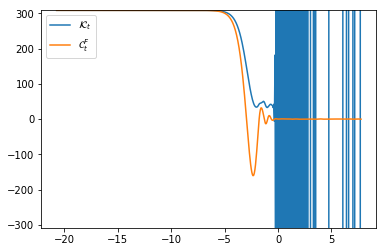

In [ ]:
maxiter=1000
d=(x[-1]-x[0])/500
xfine=np.arange(x[0],x[-1],d)
tfine=np.exp(xfine)
nfine=len(xfine)
print('nfine = ',nfine, ', len(t) =',len(t), ', len(x) = ', len(x))
print('x[ismooth] = ',x[ismooth])
# print(xfine)

kold=copy.deepcopy(interpcFF)
# knew=np.zeros(len(xfine),dtype=np.float64)
knew=interpCFF(t[0])*np.exp(-15*np.exp(xfine),dtype=np.float64)
# plt.plot(xfine, knew, label='$\mathcal{K}_t$')
plt.plot(xfine, interpcFF(xfine),label='$\mathcal{C}^{F}_t$')
plt.legend()
plt.title('Occhio a non usare cFF, bensi CFF, perche` cFF interpola male!')
plt.show()

plt.semilogx(tfine, interpCFF(tfine),label='$\mathcal{C}^{F}_t$')
plt.legend()
plt.title('Occhio a non usare cFF, bensi CFF, perche` cFF interpola male!')
plt.show()


for it in range(maxiter):
    for n in range(1,nfine):
        def integrando(y):
            if n==0: return 0
            expy=np.exp(y)
            Delta=np.exp(xfine[n])-expy
#             delta=np.log(Delta)
            return expy*interpCFP(Delta)*kold(y)
        temp=quad(integrando,xfine[0], min(xfine[n],x[ismooth]), limit=20, maxp1=20, limlst=20)[0] if n>0 else 0
        #integral in log scale
        knew[n] = interpCFF(tfine[n]) + invT * temp
#         print('n: ',n)
#         print(integrando(xfine[:n]),'\n')
#         plt.xlim((-6.1,3.5))
#         plt.ylim((-1,1))
#         plt.plot(xfine[:n],integrando(xfine[:n]))
#         plt.grid()
#         plt.show()
    err=np.sum(np.abs(knew-kold(xfine)))
    print("it:",it," err = ",err)
    plt.plot(xfine, knew, label='$\mathcal{K}_t$')
    plt.plot(xfine, interpCFF(np.exp(xfine)),label='$\mathcal{C}^{F}_t$')
    plt.ylim((-interpCFF(0),interpCFF(0)))
    plt.legend()
    plt.show()
    if err<1e-10: break
    kold=interp1d(xfine, knew, kind='cubic')

In [ ]:
plt.plot(xfine,knew)
plt.plot(xfine,interpCFF(np.exp(xfine)))
plt.xlim((-6,4))
plt.ylim((-0.6*interpCFF(0),interpCFF(0)))
plt.show()

# ismooth
print(x[ismooth])

# Diagonal correlator

Read the thermalized.gsd, 

define the potential read in the params.in,

create two snapshots and assign them the positions in the heavy trajectory,

calculate Cd.



In [ ]:
invT=1./T
pd=med.PeriodicSquareDistance

Cd_old=np.copy(Cd)
Cd  = np.zeros((nsamples, max(ntw), max(nt)), dtype=np.float64)
for isam in range(nsamples):
    for itw in range(ntw[isam]):
        snapA.particles.position[:] = poslist[isam][itw][0][:]
        for iframe in range(0, nt[isam]):
            snapB.particles.position[:] = poslist[isam][itw][iframe][:]
            Cd[isam][itw][iframe]=pair.Cd_fast(snapA=snapA, snapB=snapB, beta=invT)
            print('isam: %d, itw: %d, it: %d, Cd= %g'%(isam,itw,iframe,Cd[isam][itw][iframe]))
    obs[isam]={
         'Cd' :{'mean': np.mean(Cd [isam],axis=0), 'err': sem(Cd [isam], axis=0)},
    }
obs[nsamples]={'Cd' :{'mean': np.mean(Cd ,axis=(0,1)), 'err': sem(np.mean(Cd , axis=0), axis=0)}}



In [ ]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
for isam in range(nsamples):
#     plt.errorbar(x,obs[isam]['Cd']['mean'], yerr=obs[isam]['Cd']['err'], marker='.')
    for itw in range(ntw[isam]):
        plt.plot(x,Cd[isam][itw], color='orange')
# plt.errorbar(x,obs[nsamples]['Cd']['mean'], yerr=obs[nsamples]['Cd']['err'], marker='.',linewidth=5)
plt.legend()
plt.show()
